# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [45]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

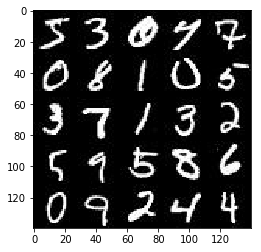

In [46]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

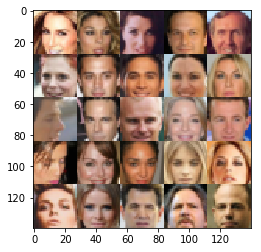

In [47]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [48]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [49]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_imgs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_data = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    
    return input_imgs, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\ProgramData\\Anaconda3\\envs\\tensorflow\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\ProgramData\\Anaconda3\\envs\\tensorflow\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\ProgramData\\Anaconda3\\envs\\tensorflow\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "C:\\ProgramData\\Anaconda3\\envs\\tensorflow\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\ProgramData\\Anaconda3\\envs\\tensorflow\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [50]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        # First convolutional layer: image_width x image_height x 3 => image_width/2 x image_height/2 x 64
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.maximum(alpha * x, x)
        x = tf.nn.dropout(x, 0.75)

        # Second convolutional layer: image_width/2 x image_height/2 x 64 => image_width/4 x image_height/4 x 128
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        x = tf.nn.dropout(x, 0.75)

        # "Another" Second convolutional layer: image_width/4 x image_height/4 x 128 => image_width/4 x image_height/4 x 256
        x = tf.layers.conv2d(x, 256, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        x = tf.nn.dropout(x, 0.75)

        # Third convolutional layer: image_width/4 x image_height/4 x 256 => image_width/8 x image_height/8 x 256
        x = tf.layers.conv2d(x, 512, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        x = tf.nn.dropout(x, 0.75)

        # Flatten it
        dim = x.get_shape().as_list()
        flat = tf.reshape(x, (-1, dim[1] * dim[2] * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [51]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        # First fully connected layer
        x = tf.layers.dense(z, 7 * 7 * 1024, kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.reshape(x, (-1, 7, 7, 1024))
        x = tf.layers.batch_normalization(x, training=is_train)
        # leaky ReLU
        x = tf.maximum(alpha * x, x)
        x = tf.nn.dropout(x, 0.75)
        
        # Transposed conv layer 7x7x1024 -> 14x14x512
        x = tf.layers.conv2d_transpose(x, 512, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        x = tf.nn.dropout(x, 0.75)

        # Transposed conv layer 14x14x512 -> 28x28x256
        x = tf.layers.conv2d_transpose(x, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        x = tf.nn.dropout(x, 0.75)

        # Transposed conv layer 28x28x256 -> 28x28x128
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        x = tf.nn.dropout(x, 0.75)

        # Output layer: Transposed conv layer 28x18x256 
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=1, padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [52]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.95))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [53]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [54]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [58]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    steps = 0    
    
    input_imgs, z_data, learning_rate_var = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_imgs, z_data, data_shape[3])

    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate_var, beta1)
    
    with tf.Session() as sess:
        init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        sess.run(init_op)
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                input_z = np.random.uniform(-1, 1, (batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_imgs: batch_images, z_data: input_z, learning_rate_var: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_imgs: batch_images, z_data: input_z, learning_rate_var: learning_rate})

                #sess.run((d_train_opt, g_train_opt), 
                #         feed_dict={input_imgs: batch_images, z_data: , learning_rate_var: learning_rate})
                if steps % 10 == 0:
                    print("Step {} ".format(steps),
                          "d_loss: {:.4f}...".format(d_loss.eval({input_imgs: batch_images, z_data: input_z})),
                          "g_loss: {:.4f}".format( g_loss.eval({z_data: input_z})))
                if steps % 100 == 0:
                    show_generator_output(sess, 10, z_data, data_shape[3], data_image_mode)
    print("Done")

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Step 10  d_loss: 0.8491... g_loss: 9.2807
Step 20  d_loss: 2.6882... g_loss: 1.5522
Step 30  d_loss: 0.6613... g_loss: 4.4240
Step 40  d_loss: 0.8882... g_loss: 4.2054
Step 50  d_loss: 0.9954... g_loss: 1.4772
Step 60  d_loss: 1.0880... g_loss: 1.9811
Step 70  d_loss: 1.3198... g_loss: 1.1867
Step 80  d_loss: 1.0544... g_loss: 1.7082
Step 90  d_loss: 0.9770... g_loss: 2.1386
Step 100  d_loss: 0.7381... g_loss: 1.3247


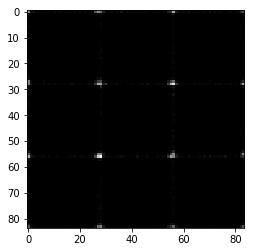

Step 110  d_loss: 0.5573... g_loss: 6.1527
Step 120  d_loss: 0.4567... g_loss: 2.0077
Step 130  d_loss: 0.3006... g_loss: 4.1889
Step 140  d_loss: 0.3185... g_loss: 3.8318
Step 150  d_loss: 6.7327... g_loss: 0.1971
Step 160  d_loss: 0.3377... g_loss: 3.0210
Step 170  d_loss: 0.2735... g_loss: 3.5840
Step 180  d_loss: 0.2518... g_loss: 4.3737
Step 190  d_loss: 2.1223... g_loss: 12.8823
Step 200  d_loss: 0.3174... g_loss: 3.6600


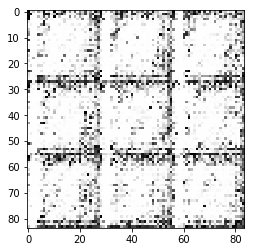

Step 210  d_loss: 0.2707... g_loss: 4.3936
Step 220  d_loss: 0.3341... g_loss: 4.0479
Step 230  d_loss: 0.3538... g_loss: 4.0985
Step 240  d_loss: 0.7589... g_loss: 1.6648
Step 250  d_loss: 0.3092... g_loss: 3.6414
Step 260  d_loss: 0.4041... g_loss: 3.8192
Step 270  d_loss: 0.4173... g_loss: 3.4932
Step 280  d_loss: 0.2967... g_loss: 4.1853
Step 290  d_loss: 0.2771... g_loss: 4.8003
Step 300  d_loss: 0.3265... g_loss: 3.1525


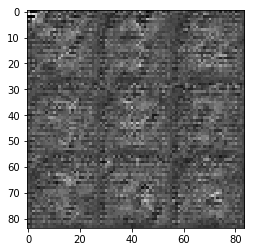

Step 310  d_loss: 0.4387... g_loss: 4.0272
Step 320  d_loss: 0.9528... g_loss: 1.3682
Step 330  d_loss: 1.1215... g_loss: 1.0225
Step 340  d_loss: 0.5313... g_loss: 2.7393
Step 350  d_loss: 0.3622... g_loss: 2.9310
Step 360  d_loss: 0.2782... g_loss: 3.5202
Step 370  d_loss: 0.3244... g_loss: 3.1630
Step 380  d_loss: 0.3743... g_loss: 2.8176
Step 390  d_loss: 0.3023... g_loss: 3.4432
Step 400  d_loss: 0.3052... g_loss: 3.8961


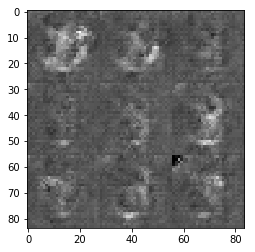

Step 410  d_loss: 0.5207... g_loss: 2.2731
Step 420  d_loss: 0.2667... g_loss: 3.6942
Step 430  d_loss: 0.6640... g_loss: 6.5524
Step 440  d_loss: 0.5753... g_loss: 2.2598
Step 450  d_loss: 0.2870... g_loss: 2.9891
Step 460  d_loss: 0.2878... g_loss: 3.4921
Step 470  d_loss: 0.3180... g_loss: 3.6781
Step 480  d_loss: 0.2559... g_loss: 3.6014
Step 490  d_loss: 0.2906... g_loss: 3.1762
Step 500  d_loss: 0.2966... g_loss: 3.8029


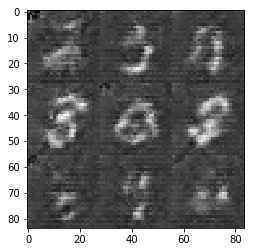

Step 510  d_loss: 0.2857... g_loss: 5.0977
Step 520  d_loss: 0.2776... g_loss: 4.8228
Step 530  d_loss: 0.2896... g_loss: 4.2757
Step 540  d_loss: 0.2966... g_loss: 7.6375
Step 550  d_loss: 1.2589... g_loss: 1.9310
Step 560  d_loss: 1.0774... g_loss: 0.8177
Step 570  d_loss: 0.4662... g_loss: 2.7630
Step 580  d_loss: 0.5955... g_loss: 1.7483
Step 590  d_loss: 1.3038... g_loss: 0.5736
Step 600  d_loss: 1.1470... g_loss: 0.9082


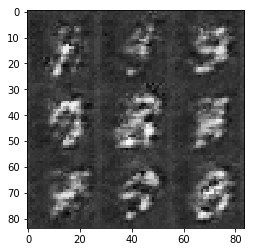

Step 610  d_loss: 1.3819... g_loss: 0.4509
Step 620  d_loss: 1.2130... g_loss: 1.6127
Step 630  d_loss: 0.6049... g_loss: 1.9206
Step 640  d_loss: 0.5406... g_loss: 3.3785
Step 650  d_loss: 0.3800... g_loss: 4.1620
Step 660  d_loss: 0.8449... g_loss: 1.0212
Step 670  d_loss: 0.4025... g_loss: 3.0066
Step 680  d_loss: 0.2654... g_loss: 6.8481
Step 690  d_loss: 0.5440... g_loss: 1.6839
Step 700  d_loss: 0.3543... g_loss: 3.4472


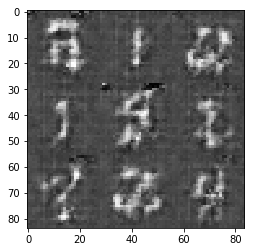

Step 710  d_loss: 0.4683... g_loss: 2.4517
Step 720  d_loss: 1.3758... g_loss: 0.8567
Step 730  d_loss: 1.3410... g_loss: 1.5720
Step 740  d_loss: 0.5316... g_loss: 1.8387
Step 750  d_loss: 0.4721... g_loss: 3.0333
Step 760  d_loss: 0.2745... g_loss: 3.3208
Step 770  d_loss: 1.0978... g_loss: 0.7929
Step 780  d_loss: 0.5371... g_loss: 1.9500
Step 790  d_loss: 0.4213... g_loss: 3.2257
Step 800  d_loss: 0.4227... g_loss: 2.0937


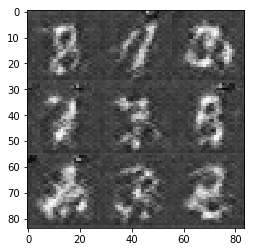

Step 810  d_loss: 0.3167... g_loss: 4.7112
Step 820  d_loss: 0.2498... g_loss: 4.1884
Step 830  d_loss: 0.3966... g_loss: 3.8882
Step 840  d_loss: 0.9054... g_loss: 5.8816
Step 850  d_loss: 0.8855... g_loss: 1.2193
Step 860  d_loss: 1.9964... g_loss: 0.4023
Step 870  d_loss: 0.8177... g_loss: 1.1668
Step 880  d_loss: 0.3888... g_loss: 2.0694
Step 890  d_loss: 0.3924... g_loss: 2.0260
Step 900  d_loss: 2.0985... g_loss: 0.4006


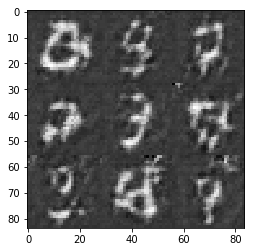

Step 910  d_loss: 0.9723... g_loss: 1.6138
Step 920  d_loss: 0.5228... g_loss: 1.9441
Step 930  d_loss: 0.2832... g_loss: 3.7486
Step 940  d_loss: 0.3475... g_loss: 3.5935
Step 950  d_loss: 0.4205... g_loss: 2.7071
Step 960  d_loss: 0.3356... g_loss: 2.9645
Step 970  d_loss: 0.3427... g_loss: 2.4740
Step 980  d_loss: 1.6808... g_loss: 1.0031
Step 990  d_loss: 1.0507... g_loss: 1.1673
Step 1000  d_loss: 0.5276... g_loss: 1.7425


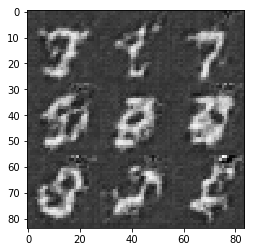

Step 1010  d_loss: 0.6457... g_loss: 3.6161
Step 1020  d_loss: 0.2786... g_loss: 3.3935
Step 1030  d_loss: 0.5461... g_loss: 5.0892
Step 1040  d_loss: 0.4435... g_loss: 3.0226
Step 1050  d_loss: 0.3315... g_loss: 3.4637
Step 1060  d_loss: 0.2626... g_loss: 4.1684
Step 1070  d_loss: 0.4279... g_loss: 2.5206
Step 1080  d_loss: 0.3793... g_loss: 2.2708
Step 1090  d_loss: 0.2444... g_loss: 4.8421
Step 1100  d_loss: 0.3490... g_loss: 3.4251


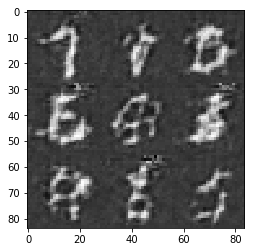

Step 1110  d_loss: 1.8294... g_loss: 0.4441
Step 1120  d_loss: 0.9399... g_loss: 2.0511
Step 1130  d_loss: 0.8740... g_loss: 0.8813
Step 1140  d_loss: 0.7262... g_loss: 1.9471
Step 1150  d_loss: 0.6309... g_loss: 1.5429
Step 1160  d_loss: 0.3848... g_loss: 2.8639
Step 1170  d_loss: 0.3520... g_loss: 4.1791
Step 1180  d_loss: 0.7222... g_loss: 1.9095
Step 1190  d_loss: 1.1304... g_loss: 1.1919
Step 1200  d_loss: 0.8445... g_loss: 1.3972


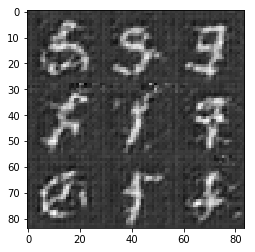

Step 1210  d_loss: 0.5623... g_loss: 1.8834
Step 1220  d_loss: 0.8955... g_loss: 1.0448
Step 1230  d_loss: 0.4737... g_loss: 1.5932
Step 1240  d_loss: 0.6014... g_loss: 1.8854
Step 1250  d_loss: 0.7128... g_loss: 1.2297
Step 1260  d_loss: 0.9278... g_loss: 1.2552
Step 1270  d_loss: 0.3484... g_loss: 4.6308
Step 1280  d_loss: 0.3960... g_loss: 4.0220
Step 1290  d_loss: 0.5221... g_loss: 1.7672
Step 1300  d_loss: 0.3871... g_loss: 2.1402


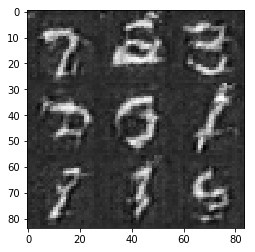

Step 1310  d_loss: 0.4922... g_loss: 1.8162
Step 1320  d_loss: 0.3631... g_loss: 5.7132
Step 1330  d_loss: 0.2679... g_loss: 4.2135
Step 1340  d_loss: 0.3778... g_loss: 2.2944
Step 1350  d_loss: 0.6544... g_loss: 2.1539
Step 1360  d_loss: 0.3905... g_loss: 4.4277
Step 1370  d_loss: 2.9780... g_loss: 4.3943
Step 1380  d_loss: 1.0182... g_loss: 0.9076
Step 1390  d_loss: 0.9437... g_loss: 3.3714
Step 1400  d_loss: 1.2943... g_loss: 3.1874


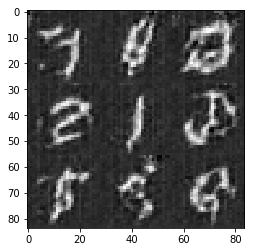

Step 1410  d_loss: 0.4535... g_loss: 2.3274
Step 1420  d_loss: 0.6843... g_loss: 2.0665
Step 1430  d_loss: 0.4806... g_loss: 1.5953
Step 1440  d_loss: 0.6475... g_loss: 2.8605
Step 1450  d_loss: 0.6191... g_loss: 4.0940
Step 1460  d_loss: 0.3291... g_loss: 2.9694
Step 1470  d_loss: 0.3844... g_loss: 2.6821
Step 1480  d_loss: 0.3610... g_loss: 2.7361
Step 1490  d_loss: 0.5891... g_loss: 3.8440
Step 1500  d_loss: 0.5319... g_loss: 1.9193


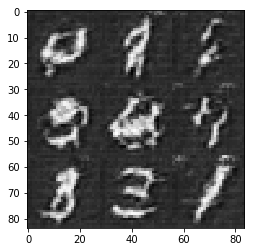

Step 1510  d_loss: 1.0240... g_loss: 0.8724
Step 1520  d_loss: 1.0241... g_loss: 3.9807
Step 1530  d_loss: 0.7120... g_loss: 1.3093
Step 1540  d_loss: 0.5955... g_loss: 2.2032
Step 1550  d_loss: 0.3039... g_loss: 3.8014
Step 1560  d_loss: 3.0124... g_loss: 6.7059
Step 1570  d_loss: 0.3602... g_loss: 4.8718
Step 1580  d_loss: 0.7461... g_loss: 1.0424
Step 1590  d_loss: 1.4824... g_loss: 0.7831
Step 1600  d_loss: 1.2330... g_loss: 2.0580


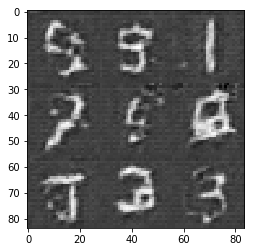

Step 1610  d_loss: 0.9594... g_loss: 1.3098
Step 1620  d_loss: 0.5080... g_loss: 1.8336
Step 1630  d_loss: 0.4933... g_loss: 2.0079
Step 1640  d_loss: 0.8455... g_loss: 3.3463
Step 1650  d_loss: 0.2751... g_loss: 2.9270
Step 1660  d_loss: 0.4862... g_loss: 2.2424
Step 1670  d_loss: 0.7004... g_loss: 6.4819
Step 1680  d_loss: 0.5628... g_loss: 1.6940
Step 1690  d_loss: 0.8503... g_loss: 1.1651
Step 1700  d_loss: 0.3431... g_loss: 3.0458


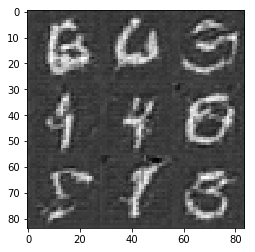

Step 1710  d_loss: 0.8618... g_loss: 3.8840
Step 1720  d_loss: 0.4779... g_loss: 2.3467
Step 1730  d_loss: 0.8170... g_loss: 2.5303
Step 1740  d_loss: 0.5427... g_loss: 1.1666
Step 1750  d_loss: 0.2402... g_loss: 4.8515
Step 1760  d_loss: 0.3740... g_loss: 3.7135
Step 1770  d_loss: 0.9242... g_loss: 4.5337
Step 1780  d_loss: 0.5487... g_loss: 1.7279
Step 1790  d_loss: 0.2568... g_loss: 4.4575
Step 1800  d_loss: 0.8893... g_loss: 1.4301


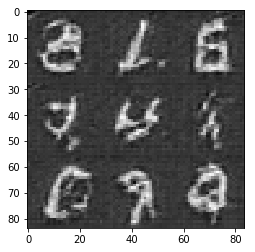

Step 1810  d_loss: 0.6827... g_loss: 2.1040
Step 1820  d_loss: 1.3844... g_loss: 2.5064
Step 1830  d_loss: 0.4752... g_loss: 2.8555
Step 1840  d_loss: 0.8397... g_loss: 1.2613
Step 1850  d_loss: 0.3491... g_loss: 3.1557
Step 1860  d_loss: 0.4430... g_loss: 3.1691
Step 1870  d_loss: 0.3579... g_loss: 3.8049


In [57]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print(mnist_dataset.shape)

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 10  d_loss: 0.5964... g_loss: 2.3077
Step 20  d_loss: 0.5096... g_loss: 2.8403
Step 30  d_loss: 0.3992... g_loss: 3.5935
Step 40  d_loss: 0.5721... g_loss: 3.5589
Step 50  d_loss: 3.6502... g_loss: 0.2341
Step 60  d_loss: 0.9364... g_loss: 2.9594
Step 70  d_loss: 0.6861... g_loss: 2.2398
Step 80  d_loss: 0.8420... g_loss: 1.3760
Step 90  d_loss: 0.5209... g_loss: 1.9254
Step 100  d_loss: 0.9569... g_loss: 1.2929


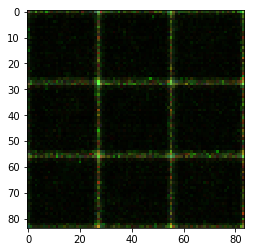

Step 110  d_loss: 0.3269... g_loss: 4.3743
Step 120  d_loss: 0.3589... g_loss: 4.0713
Step 130  d_loss: 0.3337... g_loss: 3.6750
Step 140  d_loss: 0.3068... g_loss: 4.7234
Step 150  d_loss: 0.3111... g_loss: 3.8161
Step 160  d_loss: 0.3118... g_loss: 3.6805
Step 170  d_loss: 0.2889... g_loss: 4.3864
Step 180  d_loss: 0.2940... g_loss: 3.9186
Step 190  d_loss: 0.4490... g_loss: 6.0562
Step 200  d_loss: 0.7953... g_loss: 1.5338


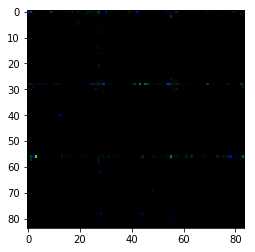

Step 210  d_loss: 0.2953... g_loss: 5.8858
Step 220  d_loss: 0.3677... g_loss: 4.1566
Step 230  d_loss: 0.2844... g_loss: 4.4007
Step 240  d_loss: 0.3250... g_loss: 4.0385
Step 250  d_loss: 0.3325... g_loss: 3.8910
Step 260  d_loss: 0.3150... g_loss: 3.7533
Step 270  d_loss: 0.3950... g_loss: 6.4594
Step 280  d_loss: 0.4564... g_loss: 2.6648
Step 290  d_loss: 0.4006... g_loss: 2.7107
Step 300  d_loss: 0.2470... g_loss: 4.8996


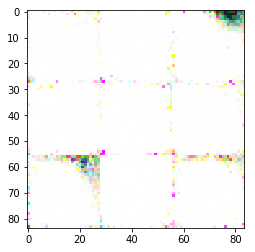

Step 310  d_loss: 0.3168... g_loss: 3.8761
Step 320  d_loss: 0.4865... g_loss: 1.9492
Step 330  d_loss: 0.3158... g_loss: 3.0028
Step 340  d_loss: 0.3399... g_loss: 2.8167
Step 350  d_loss: 0.4422... g_loss: 2.3676
Step 360  d_loss: 0.5437... g_loss: 1.9221
Step 370  d_loss: 0.3004... g_loss: 5.8396
Step 380  d_loss: 0.3277... g_loss: 5.0022
Step 390  d_loss: 0.2540... g_loss: 5.2463
Step 400  d_loss: 0.3497... g_loss: 3.5597


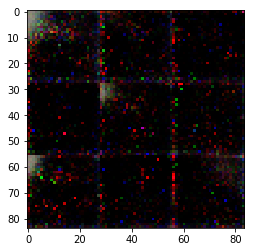

Step 410  d_loss: 0.4469... g_loss: 1.8797
Step 420  d_loss: 0.3053... g_loss: 5.9963
Step 430  d_loss: 0.3598... g_loss: 4.6085
Step 440  d_loss: 0.2597... g_loss: 4.5719
Step 450  d_loss: 0.2731... g_loss: 5.3482
Step 460  d_loss: 0.3158... g_loss: 3.6779
Step 470  d_loss: 0.3290... g_loss: 2.9327
Step 480  d_loss: 0.2655... g_loss: 5.3998
Step 490  d_loss: 0.6234... g_loss: 1.2271
Step 500  d_loss: 0.4140... g_loss: 2.6553


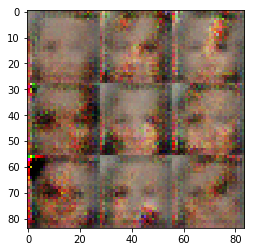

Step 510  d_loss: 0.2424... g_loss: 5.2058
Step 520  d_loss: 0.2748... g_loss: 5.2688
Step 530  d_loss: 0.2673... g_loss: 5.2669
Step 540  d_loss: 0.2665... g_loss: 3.9460
Step 550  d_loss: 0.2494... g_loss: 4.6407
Step 560  d_loss: 0.2844... g_loss: 4.2151
Step 570  d_loss: 0.3464... g_loss: 2.9333
Step 580  d_loss: 0.2505... g_loss: 5.4006
Step 590  d_loss: 0.3045... g_loss: 3.6711
Step 600  d_loss: 0.2628... g_loss: 3.0159


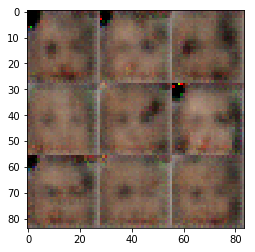

Step 610  d_loss: 0.2391... g_loss: 5.8320
Step 620  d_loss: 0.6088... g_loss: 1.8356
Step 630  d_loss: 0.4085... g_loss: 3.4553
Step 640  d_loss: 0.6198... g_loss: 4.5274
Step 650  d_loss: 0.4528... g_loss: 2.5989
Step 660  d_loss: 0.2439... g_loss: 4.1351
Step 670  d_loss: 0.7554... g_loss: 1.5408
Step 680  d_loss: 1.2255... g_loss: 0.3754
Step 690  d_loss: 0.2576... g_loss: 4.4453
Step 700  d_loss: 0.4209... g_loss: 7.8142


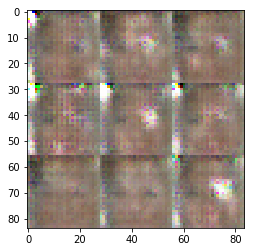

Step 710  d_loss: 0.2809... g_loss: 3.8571
Step 720  d_loss: 0.2932... g_loss: 3.9534
Step 730  d_loss: 0.3311... g_loss: 3.7494
Step 740  d_loss: 0.3110... g_loss: 3.4195
Step 750  d_loss: 0.2905... g_loss: 4.0160
Step 760  d_loss: 0.2556... g_loss: 4.6864
Step 770  d_loss: 0.2353... g_loss: 4.3456
Step 780  d_loss: 0.2850... g_loss: 2.0563
Step 790  d_loss: 0.2736... g_loss: 4.4957
Step 800  d_loss: 0.2554... g_loss: 4.2101


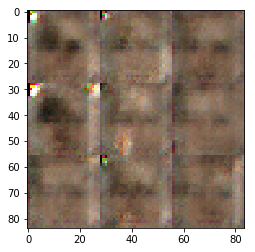

Step 810  d_loss: 0.5842... g_loss: 1.8501
Step 820  d_loss: 0.3437... g_loss: 2.5794
Step 830  d_loss: 0.4579... g_loss: 4.0731
Step 840  d_loss: 0.2924... g_loss: 3.7928
Step 850  d_loss: 0.2716... g_loss: 4.7672
Step 860  d_loss: 0.2671... g_loss: 4.3035
Step 870  d_loss: 0.2700... g_loss: 4.2040
Step 880  d_loss: 0.2595... g_loss: 4.7916
Step 890  d_loss: 0.2436... g_loss: 8.1159
Step 900  d_loss: 0.2420... g_loss: 3.4282


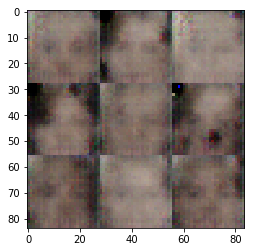

Step 910  d_loss: 0.8246... g_loss: 1.2195
Step 920  d_loss: 0.4134... g_loss: 1.8390
Step 930  d_loss: 0.3094... g_loss: 3.9157
Step 940  d_loss: 0.4145... g_loss: 3.4522
Step 950  d_loss: 0.3265... g_loss: 2.2158
Step 960  d_loss: 0.2260... g_loss: 4.5219
Step 970  d_loss: 1.3210... g_loss: 1.5559
Step 980  d_loss: 0.2229... g_loss: 5.6111
Step 990  d_loss: 0.2527... g_loss: 2.6561
Step 1000  d_loss: 0.2376... g_loss: 4.8636


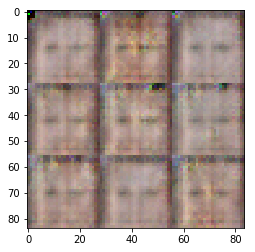

Step 1010  d_loss: 0.2590... g_loss: 5.1046
Step 1020  d_loss: 0.2515... g_loss: 4.2365
Step 1030  d_loss: 0.3681... g_loss: 2.8548
Step 1040  d_loss: 0.3200... g_loss: 2.9898
Step 1050  d_loss: 0.3257... g_loss: 3.1149
Step 1060  d_loss: 0.2291... g_loss: 4.8633
Step 1070  d_loss: 0.2504... g_loss: 3.3300
Step 1080  d_loss: 0.2436... g_loss: 5.0898
Step 1090  d_loss: 0.4357... g_loss: 7.3217
Step 1100  d_loss: 0.2799... g_loss: 4.0745


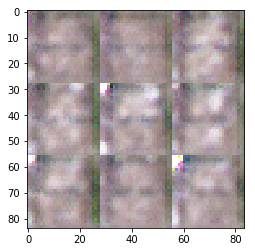

Step 1110  d_loss: 0.2228... g_loss: 5.4561
Step 1120  d_loss: 0.2387... g_loss: 5.1630
Step 1130  d_loss: 0.2556... g_loss: 6.5752
Step 1140  d_loss: 0.2938... g_loss: 2.5137
Step 1150  d_loss: 0.2338... g_loss: 6.3901
Step 1160  d_loss: 0.2220... g_loss: 8.0162
Step 1170  d_loss: 0.2369... g_loss: 4.7638
Step 1180  d_loss: 0.2519... g_loss: 4.8403
Step 1190  d_loss: 0.2219... g_loss: 5.5596
Step 1200  d_loss: 0.3829... g_loss: 1.8217


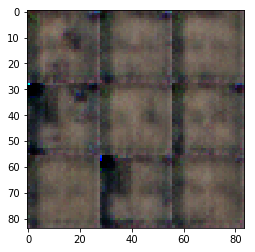

Step 1210  d_loss: 0.2414... g_loss: 4.9704
Step 1220  d_loss: 0.4598... g_loss: 3.7404
Step 1230  d_loss: 0.4689... g_loss: 3.7150
Step 1240  d_loss: 0.3799... g_loss: 3.9195
Step 1250  d_loss: 0.2579... g_loss: 4.6343
Step 1260  d_loss: 0.2747... g_loss: 4.3973
Step 1270  d_loss: 0.2289... g_loss: 5.4892
Step 1280  d_loss: 0.3300... g_loss: 2.4164
Step 1290  d_loss: 0.2364... g_loss: 5.1990
Step 1300  d_loss: 0.4334... g_loss: 9.5793


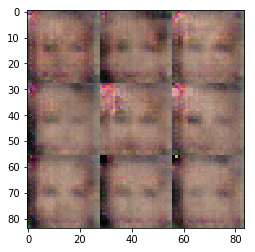

Step 1310  d_loss: 0.2713... g_loss: 6.1305
Step 1320  d_loss: 0.2685... g_loss: 2.9873
Step 1330  d_loss: 1.0225... g_loss: 2.7289
Step 1340  d_loss: 0.2264... g_loss: 7.2707
Step 1350  d_loss: 0.4431... g_loss: 10.7131
Step 1360  d_loss: 0.2164... g_loss: 9.4797
Step 1370  d_loss: 0.2485... g_loss: 3.6744
Step 1380  d_loss: 1.9440... g_loss: 11.3640
Step 1390  d_loss: 0.4209... g_loss: 2.6466
Step 1400  d_loss: 0.2513... g_loss: 7.8607


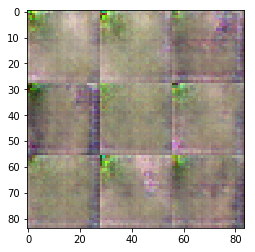

Step 1410  d_loss: 0.2674... g_loss: 11.8779
Step 1420  d_loss: 0.2363... g_loss: 8.6752
Step 1430  d_loss: 0.6011... g_loss: 3.2597
Step 1440  d_loss: 0.2789... g_loss: 3.0535
Step 1450  d_loss: 0.3106... g_loss: 3.4967
Step 1460  d_loss: 1.8138... g_loss: 0.4046
Step 1470  d_loss: 1.2677... g_loss: 0.6519
Step 1480  d_loss: 1.0144... g_loss: 1.0352
Step 1490  d_loss: 1.1925... g_loss: 1.1987
Step 1500  d_loss: 0.9443... g_loss: 1.5142


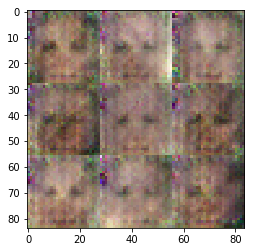

Step 1510  d_loss: 0.9704... g_loss: 1.0354
Step 1520  d_loss: 1.3935... g_loss: 0.4760
Step 1530  d_loss: 1.1812... g_loss: 1.0370
Step 1540  d_loss: 1.1494... g_loss: 1.0192
Step 1550  d_loss: 0.9374... g_loss: 1.2942
Step 1560  d_loss: 0.9348... g_loss: 1.4106
Step 1570  d_loss: 0.9903... g_loss: 1.2539
Step 1580  d_loss: 1.1309... g_loss: 1.3725
Step 1590  d_loss: 2.3219... g_loss: 0.3455
Step 1600  d_loss: 0.5877... g_loss: 1.6908


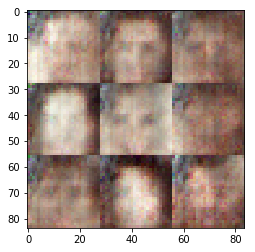

Step 1610  d_loss: 1.8031... g_loss: 0.5364
Step 1620  d_loss: 1.9302... g_loss: 0.3389
Step 1630  d_loss: 0.9972... g_loss: 0.6523
Step 1640  d_loss: 0.8673... g_loss: 0.8687
Step 1650  d_loss: 0.7349... g_loss: 0.9615
Step 1660  d_loss: 0.6460... g_loss: 1.4420
Step 1670  d_loss: 0.7510... g_loss: 2.2619
Step 1680  d_loss: 1.5360... g_loss: 2.8617
Step 1690  d_loss: 0.9967... g_loss: 1.7771
Step 1700  d_loss: 0.6131... g_loss: 1.5860


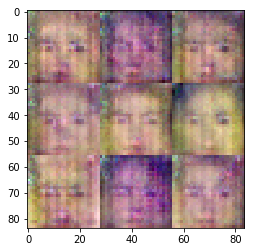

Step 1710  d_loss: 1.1777... g_loss: 1.1038
Step 1720  d_loss: 0.7797... g_loss: 0.9988
Step 1730  d_loss: 1.6173... g_loss: 0.5721
Step 1740  d_loss: 1.1385... g_loss: 1.1344
Step 1750  d_loss: 1.2739... g_loss: 0.6566
Step 1760  d_loss: 0.5577... g_loss: 1.4060
Step 1770  d_loss: 0.6180... g_loss: 1.3776
Step 1780  d_loss: 1.3635... g_loss: 0.8600
Step 1790  d_loss: 0.7762... g_loss: 2.0075
Step 1800  d_loss: 1.5672... g_loss: 1.0645


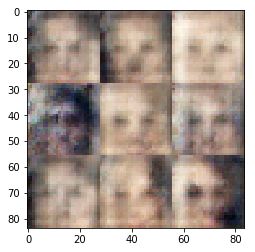

Step 1810  d_loss: 1.4850... g_loss: 0.7005
Step 1820  d_loss: 0.9164... g_loss: 1.7671
Step 1830  d_loss: 0.6898... g_loss: 1.5858
Step 1840  d_loss: 1.0101... g_loss: 2.6276
Step 1850  d_loss: 1.2571... g_loss: 1.1140
Step 1860  d_loss: 0.8701... g_loss: 1.2418
Step 1870  d_loss: 1.4839... g_loss: 0.6222
Step 1880  d_loss: 1.0544... g_loss: 2.3583
Step 1890  d_loss: 1.5885... g_loss: 0.6462
Step 1900  d_loss: 1.3278... g_loss: 1.1963


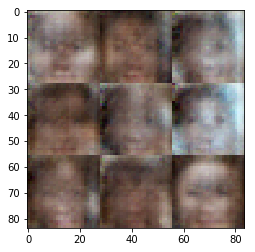

Step 1910  d_loss: 1.2515... g_loss: 1.1550
Step 1920  d_loss: 1.1742... g_loss: 1.0263
Step 1930  d_loss: 1.1935... g_loss: 0.7696
Step 1940  d_loss: 1.0734... g_loss: 1.3668
Step 1950  d_loss: 1.1144... g_loss: 0.6026
Step 1960  d_loss: 1.1375... g_loss: 0.8078
Step 1970  d_loss: 0.9629... g_loss: 0.9012
Step 1980  d_loss: 0.7180... g_loss: 1.4304
Step 1990  d_loss: 0.7996... g_loss: 1.5191
Step 2000  d_loss: 1.1027... g_loss: 1.1046


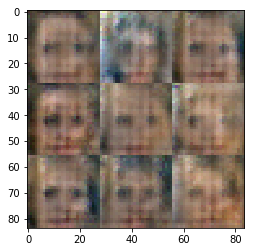

Step 2010  d_loss: 1.2914... g_loss: 1.9429
Step 2020  d_loss: 1.2525... g_loss: 0.7993
Step 2030  d_loss: 0.8983... g_loss: 1.6937
Step 2040  d_loss: 1.1067... g_loss: 0.9166
Step 2050  d_loss: 0.8386... g_loss: 0.9740
Step 2060  d_loss: 1.2511... g_loss: 2.7896
Step 2070  d_loss: 0.9285... g_loss: 1.3465
Step 2080  d_loss: 1.4623... g_loss: 0.8029
Step 2090  d_loss: 0.9159... g_loss: 1.4924
Step 2100  d_loss: 0.9054... g_loss: 1.1925


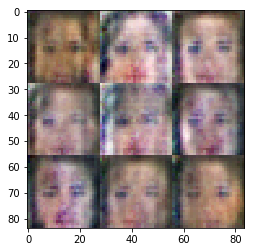

Step 2110  d_loss: 1.4419... g_loss: 0.6536
Step 2120  d_loss: 1.5867... g_loss: 0.7392
Step 2130  d_loss: 1.4977... g_loss: 0.8384
Step 2140  d_loss: 0.7949... g_loss: 0.9487
Step 2150  d_loss: 1.4377... g_loss: 1.0038
Step 2160  d_loss: 1.4738... g_loss: 0.9229
Step 2170  d_loss: 1.2790... g_loss: 1.1772
Step 2180  d_loss: 1.6273... g_loss: 0.6684
Step 2190  d_loss: 1.0753... g_loss: 1.4559
Step 2200  d_loss: 0.8331... g_loss: 1.1855


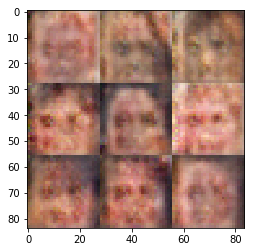

Step 2210  d_loss: 1.5552... g_loss: 0.6760
Step 2220  d_loss: 1.4118... g_loss: 1.3611
Step 2230  d_loss: 1.2215... g_loss: 1.4050
Step 2240  d_loss: 1.2068... g_loss: 0.8535
Step 2250  d_loss: 0.7991... g_loss: 1.3688
Step 2260  d_loss: 1.2394... g_loss: 1.1700
Step 2270  d_loss: 0.8073... g_loss: 0.9054
Step 2280  d_loss: 1.6748... g_loss: 0.7108
Step 2290  d_loss: 1.5638... g_loss: 0.5160
Step 2300  d_loss: 1.7763... g_loss: 0.6042


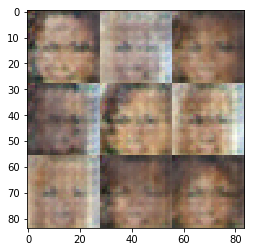

Step 2310  d_loss: 1.0409... g_loss: 0.9813
Step 2320  d_loss: 0.6499... g_loss: 1.3436
Step 2330  d_loss: 1.3687... g_loss: 0.8544
Step 2340  d_loss: 1.3670... g_loss: 1.1182
Step 2350  d_loss: 1.5403... g_loss: 0.8238
Step 2360  d_loss: 1.4297... g_loss: 0.4272
Step 2370  d_loss: 0.6562... g_loss: 1.5825
Step 2380  d_loss: 1.2339... g_loss: 0.4503
Step 2390  d_loss: 1.5019... g_loss: 0.8472
Step 2400  d_loss: 1.4922... g_loss: 0.8968


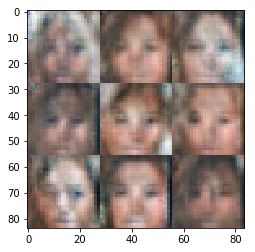

Step 2410  d_loss: 0.9144... g_loss: 1.2326
Step 2420  d_loss: 1.1518... g_loss: 0.6995
Step 2430  d_loss: 1.3760... g_loss: 0.5861
Step 2440  d_loss: 0.8581... g_loss: 1.3634
Step 2450  d_loss: 1.2108... g_loss: 1.2184
Step 2460  d_loss: 0.8697... g_loss: 1.2020
Step 2470  d_loss: 1.0786... g_loss: 0.8123
Step 2480  d_loss: 1.0226... g_loss: 0.7193
Step 2490  d_loss: 1.0365... g_loss: 0.5252
Step 2500  d_loss: 1.0006... g_loss: 1.2251


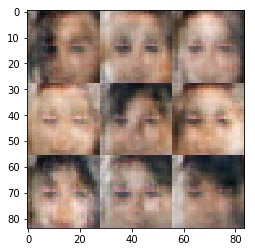

Step 2510  d_loss: 1.1658... g_loss: 0.8132
Step 2520  d_loss: 1.0913... g_loss: 0.7987
Step 2530  d_loss: 0.8425... g_loss: 1.2740
Step 2540  d_loss: 0.9083... g_loss: 1.0538
Step 2550  d_loss: 1.0662... g_loss: 0.6729
Step 2560  d_loss: 1.5105... g_loss: 0.5328
Step 2570  d_loss: 0.9887... g_loss: 0.7553
Step 2580  d_loss: 1.1165... g_loss: 0.9910
Step 2590  d_loss: 1.2225... g_loss: 0.5536
Step 2600  d_loss: 1.6389... g_loss: 0.6844


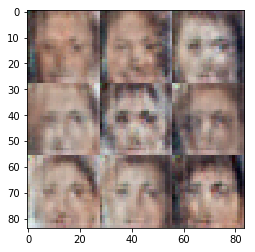

Step 2610  d_loss: 0.9866... g_loss: 1.0667
Step 2620  d_loss: 1.9010... g_loss: 0.5135
Step 2630  d_loss: 1.2802... g_loss: 0.7678
Step 2640  d_loss: 1.0320... g_loss: 1.1344
Step 2650  d_loss: 1.2493... g_loss: 1.0423
Step 2660  d_loss: 0.8324... g_loss: 1.6936
Step 2670  d_loss: 1.4191... g_loss: 0.7585
Step 2680  d_loss: 1.2854... g_loss: 0.9745
Step 2690  d_loss: 1.1285... g_loss: 0.6792
Step 2700  d_loss: 1.3347... g_loss: 0.6784


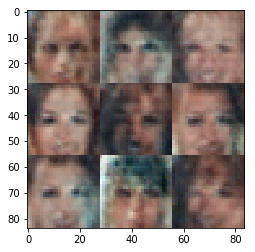

Step 2710  d_loss: 1.1226... g_loss: 1.1118
Step 2720  d_loss: 1.1229... g_loss: 1.2062
Step 2730  d_loss: 1.5422... g_loss: 0.8775
Step 2740  d_loss: 1.2666... g_loss: 0.6291
Step 2750  d_loss: 0.9686... g_loss: 1.2437
Step 2760  d_loss: 1.1513... g_loss: 0.8738
Step 2770  d_loss: 1.5442... g_loss: 1.0621
Step 2780  d_loss: 1.0702... g_loss: 0.7486
Step 2790  d_loss: 1.1814... g_loss: 0.8921
Step 2800  d_loss: 1.2353... g_loss: 0.8576


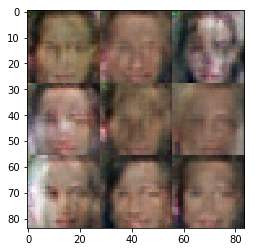

Step 2810  d_loss: 0.9326... g_loss: 1.1307
Step 2820  d_loss: 1.2958... g_loss: 0.9420
Step 2830  d_loss: 1.0026... g_loss: 1.0671
Step 2840  d_loss: 1.1984... g_loss: 0.9838
Step 2850  d_loss: 0.9595... g_loss: 1.3849
Step 2860  d_loss: 1.0912... g_loss: 1.2115
Step 2870  d_loss: 1.2827... g_loss: 1.0580
Step 2880  d_loss: 0.9861... g_loss: 1.0838
Step 2890  d_loss: 1.6378... g_loss: 1.1887
Step 2900  d_loss: 1.4543... g_loss: 0.5361


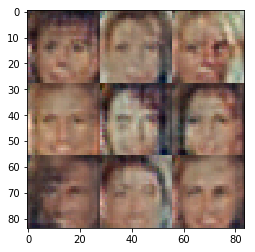

Step 2910  d_loss: 1.2629... g_loss: 0.9361
Step 2920  d_loss: 0.9091... g_loss: 1.3832
Step 2930  d_loss: 1.5045... g_loss: 1.1724
Step 2940  d_loss: 1.2857... g_loss: 0.8098
Step 2950  d_loss: 1.3682... g_loss: 0.7974
Step 2960  d_loss: 1.0600... g_loss: 0.9040
Step 2970  d_loss: 1.3447... g_loss: 0.8498
Step 2980  d_loss: 1.3573... g_loss: 0.4737
Step 2990  d_loss: 1.5750... g_loss: 1.1008
Step 3000  d_loss: 1.1936... g_loss: 0.9855


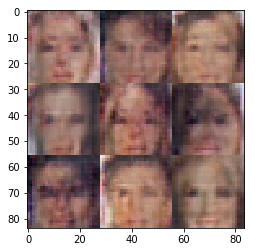

Step 3010  d_loss: 1.3424... g_loss: 1.1386
Step 3020  d_loss: 1.2878... g_loss: 0.6330
Step 3030  d_loss: 1.1678... g_loss: 0.9781
Step 3040  d_loss: 1.3486... g_loss: 0.7332
Step 3050  d_loss: 1.0863... g_loss: 1.2461
Step 3060  d_loss: 1.1098... g_loss: 0.8760
Step 3070  d_loss: 1.4345... g_loss: 0.7107
Step 3080  d_loss: 0.9334... g_loss: 1.0212
Step 3090  d_loss: 0.9659... g_loss: 1.0693
Step 3100  d_loss: 1.1841... g_loss: 1.1750


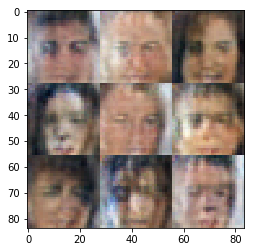

Step 3110  d_loss: 1.0550... g_loss: 1.1220
Step 3120  d_loss: 1.8195... g_loss: 0.6685
Step 3130  d_loss: 1.1560... g_loss: 0.8230
Step 3140  d_loss: 1.8370... g_loss: 0.3992
Step 3150  d_loss: 1.2585... g_loss: 0.9317
Step 3160  d_loss: 0.9748... g_loss: 1.0140
Step 3170  d_loss: 1.3829... g_loss: 1.0559
Step 3180  d_loss: 1.2186... g_loss: 1.1315
Step 3190  d_loss: 1.2008... g_loss: 0.6316
Step 3200  d_loss: 1.2974... g_loss: 0.5254


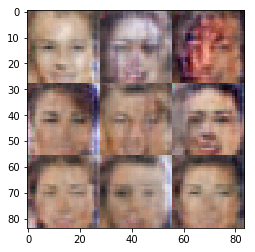

Step 3210  d_loss: 1.1629... g_loss: 1.0070
Step 3220  d_loss: 1.1780... g_loss: 0.9402
Step 3230  d_loss: 1.6966... g_loss: 0.5398
Step 3240  d_loss: 1.1943... g_loss: 1.0761
Step 3250  d_loss: 1.2702... g_loss: 1.2335
Step 3260  d_loss: 1.0116... g_loss: 1.4004
Step 3270  d_loss: 1.4076... g_loss: 0.8535
Step 3280  d_loss: 1.4062... g_loss: 0.6708
Step 3290  d_loss: 1.2064... g_loss: 0.8307
Step 3300  d_loss: 1.2102... g_loss: 0.7973


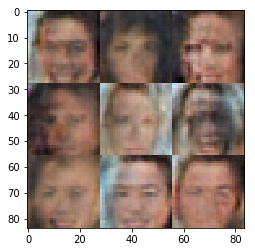

Step 3310  d_loss: 1.1804... g_loss: 0.6754
Step 3320  d_loss: 1.4066... g_loss: 0.8170
Step 3330  d_loss: 0.9681... g_loss: 1.3798
Step 3340  d_loss: 0.9431... g_loss: 1.1103
Step 3350  d_loss: 0.8784... g_loss: 1.2893
Step 3360  d_loss: 1.0968... g_loss: 0.9104
Step 3370  d_loss: 1.4424... g_loss: 0.6332
Step 3380  d_loss: 1.2420... g_loss: 0.9268
Step 3390  d_loss: 1.1109... g_loss: 0.9703
Step 3400  d_loss: 1.2043... g_loss: 0.9562


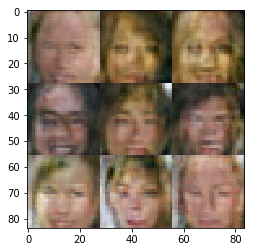

Step 3410  d_loss: 1.3233... g_loss: 0.9177
Step 3420  d_loss: 1.3509... g_loss: 0.7607
Step 3430  d_loss: 1.1034... g_loss: 0.8292
Step 3440  d_loss: 1.2159... g_loss: 0.8258
Step 3450  d_loss: 1.1140... g_loss: 1.1510
Step 3460  d_loss: 1.2525... g_loss: 1.2262
Step 3470  d_loss: 1.6553... g_loss: 0.7949
Step 3480  d_loss: 1.4852... g_loss: 0.9164
Step 3490  d_loss: 1.0844... g_loss: 0.9389
Step 3500  d_loss: 0.9807... g_loss: 1.1440


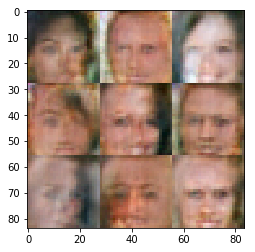

Step 3510  d_loss: 1.1439... g_loss: 0.7821
Step 3520  d_loss: 1.4421... g_loss: 0.7176
Step 3530  d_loss: 1.3662... g_loss: 0.5330
Step 3540  d_loss: 1.1861... g_loss: 0.7908
Step 3550  d_loss: 0.9988... g_loss: 1.0701
Step 3560  d_loss: 1.1912... g_loss: 0.8396
Step 3570  d_loss: 1.5449... g_loss: 0.6189
Step 3580  d_loss: 1.3052... g_loss: 0.9287
Step 3590  d_loss: 1.3908... g_loss: 0.7253
Step 3600  d_loss: 1.0740... g_loss: 1.0910


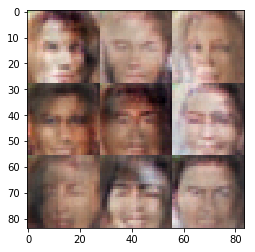

Step 3610  d_loss: 1.5162... g_loss: 0.7475
Step 3620  d_loss: 1.2433... g_loss: 1.1533
Step 3630  d_loss: 1.0467... g_loss: 1.1004
Step 3640  d_loss: 0.9934... g_loss: 1.2055
Step 3650  d_loss: 1.4994... g_loss: 0.8931
Step 3660  d_loss: 1.1584... g_loss: 1.1273
Step 3670  d_loss: 1.2320... g_loss: 0.7317
Step 3680  d_loss: 1.3044... g_loss: 0.8768
Step 3690  d_loss: 1.4036... g_loss: 0.8121
Step 3700  d_loss: 1.5026... g_loss: 0.9166


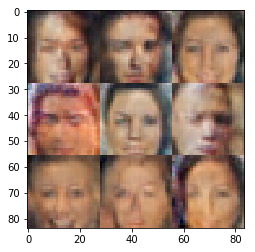

Step 3710  d_loss: 1.2089... g_loss: 0.8233
Step 3720  d_loss: 1.1944... g_loss: 1.0060
Step 3730  d_loss: 1.3197... g_loss: 0.8390
Step 3740  d_loss: 1.2171... g_loss: 0.8566
Step 3750  d_loss: 0.9546... g_loss: 1.0029
Step 3760  d_loss: 1.3075... g_loss: 0.8389
Step 3770  d_loss: 0.9619... g_loss: 1.0813
Step 3780  d_loss: 1.3961... g_loss: 0.7865
Step 3790  d_loss: 1.2316... g_loss: 0.7557
Step 3800  d_loss: 1.3900... g_loss: 0.6186


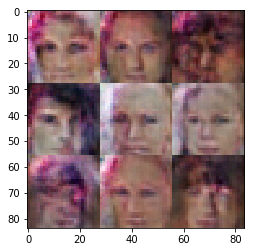

Step 3810  d_loss: 1.0280... g_loss: 0.9200
Step 3820  d_loss: 1.6328... g_loss: 0.9420
Step 3830  d_loss: 1.1480... g_loss: 0.8783
Step 3840  d_loss: 1.2893... g_loss: 0.6846
Step 3850  d_loss: 1.2908... g_loss: 0.9965
Step 3860  d_loss: 1.0798... g_loss: 1.2888
Step 3870  d_loss: 1.2041... g_loss: 0.9251
Step 3880  d_loss: 1.4940... g_loss: 0.6009
Step 3890  d_loss: 1.5614... g_loss: 0.7000
Step 3900  d_loss: 1.2903... g_loss: 0.6654


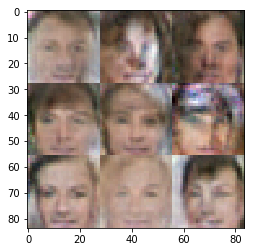

Step 3910  d_loss: 1.3706... g_loss: 0.6735
Step 3920  d_loss: 1.2669... g_loss: 1.2013
Step 3930  d_loss: 1.3940... g_loss: 0.8806
Step 3940  d_loss: 1.1644... g_loss: 0.6712
Step 3950  d_loss: 1.3803... g_loss: 0.6146
Step 3960  d_loss: 1.0024... g_loss: 1.1037
Step 3970  d_loss: 1.3587... g_loss: 0.8384
Step 3980  d_loss: 1.2403... g_loss: 0.9903
Step 3990  d_loss: 1.3318... g_loss: 0.8996
Step 4000  d_loss: 1.2146... g_loss: 1.0449


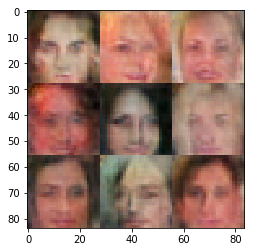

Step 4010  d_loss: 1.0866... g_loss: 0.9001
Step 4020  d_loss: 1.4590... g_loss: 0.7376
Step 4030  d_loss: 1.7480... g_loss: 0.5467
Step 4040  d_loss: 1.3573... g_loss: 0.8203
Step 4050  d_loss: 1.4800... g_loss: 1.1724
Step 4060  d_loss: 1.5309... g_loss: 0.7417
Step 4070  d_loss: 1.2699... g_loss: 0.6160
Step 4080  d_loss: 1.2510... g_loss: 0.9695
Step 4090  d_loss: 1.1890... g_loss: 0.9305
Step 4100  d_loss: 1.1581... g_loss: 0.9975


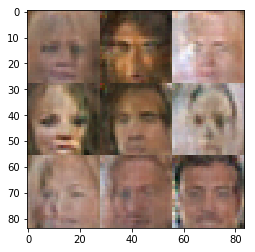

Step 4110  d_loss: 1.2026... g_loss: 0.9605
Step 4120  d_loss: 1.2712... g_loss: 0.6582
Step 4130  d_loss: 1.3321... g_loss: 0.7924
Step 4140  d_loss: 1.2338... g_loss: 0.9597
Step 4150  d_loss: 1.3640... g_loss: 0.7037
Step 4160  d_loss: 1.5734... g_loss: 0.6179
Step 4170  d_loss: 1.3382... g_loss: 0.8237
Step 4180  d_loss: 1.1763... g_loss: 1.0760
Step 4190  d_loss: 1.2130... g_loss: 1.1035
Step 4200  d_loss: 1.2688... g_loss: 0.7213


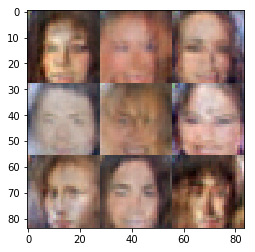

Step 4210  d_loss: 1.1718... g_loss: 0.9149
Step 4220  d_loss: 1.4718... g_loss: 0.5234
Step 4230  d_loss: 1.1049... g_loss: 1.1468
Step 4240  d_loss: 1.3828... g_loss: 0.8966
Step 4250  d_loss: 1.4842... g_loss: 0.7711
Step 4260  d_loss: 1.2891... g_loss: 0.7517
Step 4270  d_loss: 1.3145... g_loss: 0.7615
Step 4280  d_loss: 1.5256... g_loss: 0.7408
Step 4290  d_loss: 1.4962... g_loss: 0.6904
Step 4300  d_loss: 1.2727... g_loss: 0.7923


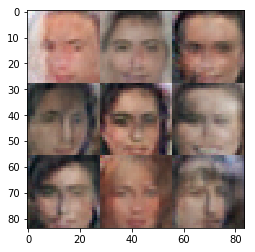

Step 4310  d_loss: 1.4126... g_loss: 0.7033
Step 4320  d_loss: 1.2470... g_loss: 0.8213
Step 4330  d_loss: 1.3962... g_loss: 0.7754
Step 4340  d_loss: 1.3826... g_loss: 0.9832
Step 4350  d_loss: 1.6218... g_loss: 0.6005
Step 4360  d_loss: 1.4149... g_loss: 0.8141
Step 4370  d_loss: 1.0794... g_loss: 0.9722
Step 4380  d_loss: 1.8126... g_loss: 0.7441
Step 4390  d_loss: 1.5052... g_loss: 0.5384
Step 4400  d_loss: 1.2773... g_loss: 0.8718


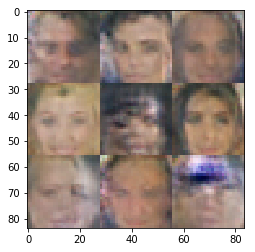

Step 4410  d_loss: 1.0793... g_loss: 0.6606
Step 4420  d_loss: 1.4856... g_loss: 0.6245
Step 4430  d_loss: 1.2738... g_loss: 0.8138
Step 4440  d_loss: 1.3043... g_loss: 0.6543
Step 4450  d_loss: 1.3217... g_loss: 0.7019
Step 4460  d_loss: 1.3038... g_loss: 0.7685
Step 4470  d_loss: 1.2771... g_loss: 0.8420
Step 4480  d_loss: 1.2829... g_loss: 0.8051
Step 4490  d_loss: 1.4766... g_loss: 0.7260
Step 4500  d_loss: 1.3119... g_loss: 0.8262


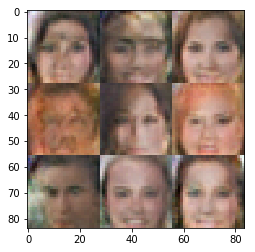

Step 4510  d_loss: 1.3112... g_loss: 0.7292
Step 4520  d_loss: 1.3871... g_loss: 0.5438
Step 4530  d_loss: 1.4015... g_loss: 0.7504
Step 4540  d_loss: 1.3898... g_loss: 0.6984
Step 4550  d_loss: 1.2900... g_loss: 0.8583
Step 4560  d_loss: 1.3015... g_loss: 0.6904
Step 4570  d_loss: 1.1506... g_loss: 1.1078
Step 4580  d_loss: 1.5720... g_loss: 0.5449
Step 4590  d_loss: 1.3249... g_loss: 0.8490
Step 4600  d_loss: 1.2368... g_loss: 0.8719


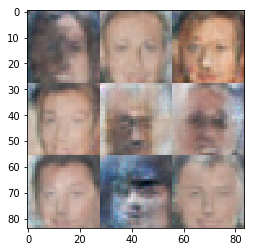

Step 4610  d_loss: 1.1902... g_loss: 0.8725
Step 4620  d_loss: 1.2933... g_loss: 0.7275
Step 4630  d_loss: 1.4494... g_loss: 0.5559
Step 4640  d_loss: 1.3857... g_loss: 0.8408
Step 4650  d_loss: 1.1787... g_loss: 0.6286
Step 4660  d_loss: 1.1847... g_loss: 0.9225
Step 4670  d_loss: 1.3140... g_loss: 0.7234
Step 4680  d_loss: 1.5978... g_loss: 0.7146
Step 4690  d_loss: 1.2038... g_loss: 0.7109
Step 4700  d_loss: 1.3623... g_loss: 0.8208


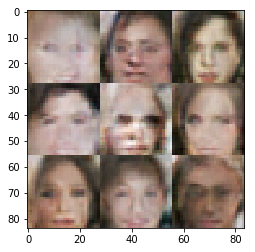

Step 4710  d_loss: 1.2385... g_loss: 0.8011
Step 4720  d_loss: 1.2401... g_loss: 0.9382
Step 4730  d_loss: 1.1592... g_loss: 1.0187
Step 4740  d_loss: 1.2699... g_loss: 0.8782
Step 4750  d_loss: 1.1021... g_loss: 0.9426
Step 4760  d_loss: 1.3974... g_loss: 0.7202
Step 4770  d_loss: 1.1838... g_loss: 0.8318
Step 4780  d_loss: 1.5064... g_loss: 0.8294
Step 4790  d_loss: 1.1185... g_loss: 0.7369
Step 4800  d_loss: 1.1331... g_loss: 0.9692


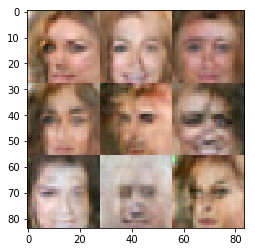

Step 4810  d_loss: 0.9885... g_loss: 0.9015
Step 4820  d_loss: 1.4259... g_loss: 0.6578
Step 4830  d_loss: 1.5261... g_loss: 0.7121
Step 4840  d_loss: 1.2458... g_loss: 0.8024
Step 4850  d_loss: 1.5184... g_loss: 0.6138
Step 4860  d_loss: 1.2439... g_loss: 0.6111
Step 4870  d_loss: 1.4559... g_loss: 0.7209
Step 4880  d_loss: 1.6425... g_loss: 0.7016
Step 4890  d_loss: 1.3528... g_loss: 0.6981
Step 4900  d_loss: 1.5092... g_loss: 0.8183


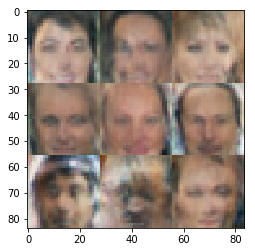

Step 4910  d_loss: 1.1599... g_loss: 0.8059
Step 4920  d_loss: 1.3728... g_loss: 0.7995
Step 4930  d_loss: 1.2400... g_loss: 0.6915
Step 4940  d_loss: 1.2939... g_loss: 0.7210
Step 4950  d_loss: 1.5100... g_loss: 0.5618
Step 4960  d_loss: 1.1724... g_loss: 1.0116
Step 4970  d_loss: 1.4250... g_loss: 0.4787
Step 4980  d_loss: 1.2594... g_loss: 0.8231
Step 4990  d_loss: 1.4489... g_loss: 0.9390
Step 5000  d_loss: 1.3407... g_loss: 0.8228


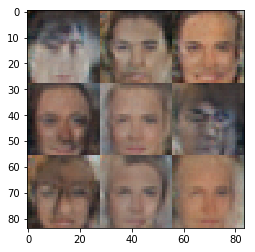

Step 5010  d_loss: 1.2635... g_loss: 0.7714
Step 5020  d_loss: 1.2388... g_loss: 1.0072
Step 5030  d_loss: 1.4059... g_loss: 0.7079
Step 5040  d_loss: 1.4131... g_loss: 0.7939
Step 5050  d_loss: 1.4431... g_loss: 0.7485
Step 5060  d_loss: 1.1888... g_loss: 0.8257
Step 5070  d_loss: 1.4872... g_loss: 0.7841
Step 5080  d_loss: 1.2402... g_loss: 0.8776
Step 5090  d_loss: 1.4953... g_loss: 0.6156
Step 5100  d_loss: 1.2894... g_loss: 0.8018


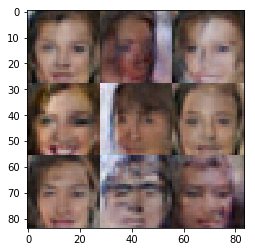

Step 5110  d_loss: 1.2042... g_loss: 0.8905
Step 5120  d_loss: 1.3814... g_loss: 0.7966
Step 5130  d_loss: 1.1944... g_loss: 0.8533
Step 5140  d_loss: 1.4364... g_loss: 0.6944
Step 5150  d_loss: 1.3760... g_loss: 0.8576
Step 5160  d_loss: 1.3070... g_loss: 0.8032
Step 5170  d_loss: 1.5731... g_loss: 0.6329
Step 5180  d_loss: 1.2735... g_loss: 0.8872
Step 5190  d_loss: 1.3476... g_loss: 0.8297
Step 5200  d_loss: 1.4474... g_loss: 0.6518


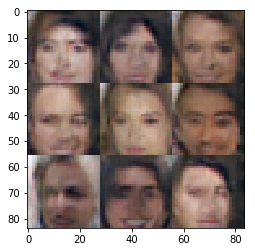

Step 5210  d_loss: 1.1486... g_loss: 0.7375
Step 5220  d_loss: 1.3285... g_loss: 0.8355
Step 5230  d_loss: 1.1794... g_loss: 0.9171
Step 5240  d_loss: 1.3595... g_loss: 0.7667
Step 5250  d_loss: 1.5910... g_loss: 0.8277
Step 5260  d_loss: 1.4683... g_loss: 0.7521
Step 5270  d_loss: 1.4328... g_loss: 0.6952
Step 5280  d_loss: 1.3585... g_loss: 0.6557
Step 5290  d_loss: 1.2032... g_loss: 0.7242
Step 5300  d_loss: 1.5027... g_loss: 0.7939


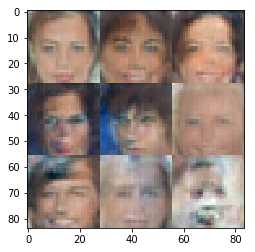

Step 5310  d_loss: 1.3721... g_loss: 0.7177
Step 5320  d_loss: 1.2691... g_loss: 0.9226
Step 5330  d_loss: 1.4072... g_loss: 0.7988
Step 5340  d_loss: 1.5111... g_loss: 0.8260
Step 5350  d_loss: 1.1377... g_loss: 0.8379
Step 5360  d_loss: 1.4222... g_loss: 0.7245
Step 5370  d_loss: 1.2927... g_loss: 0.7886
Step 5380  d_loss: 1.5149... g_loss: 0.5974
Step 5390  d_loss: 1.4061... g_loss: 0.7351
Step 5400  d_loss: 1.3262... g_loss: 0.7970


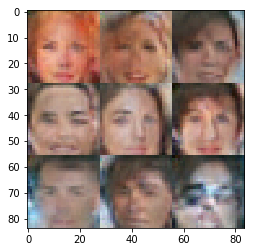

Step 5410  d_loss: 0.9884... g_loss: 1.0359
Step 5420  d_loss: 1.3195... g_loss: 0.8676
Step 5430  d_loss: 1.2563... g_loss: 0.8356
Step 5440  d_loss: 1.4255... g_loss: 0.9489
Step 5450  d_loss: 1.1426... g_loss: 0.7893
Step 5460  d_loss: 1.4625... g_loss: 0.7110
Step 5470  d_loss: 1.3584... g_loss: 0.8847
Step 5480  d_loss: 1.5750... g_loss: 0.6298
Step 5490  d_loss: 1.3985... g_loss: 0.7147
Step 5500  d_loss: 1.1824... g_loss: 0.9195


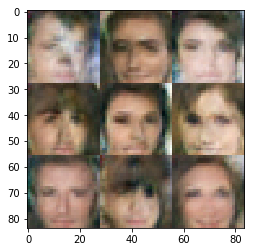

Step 5510  d_loss: 1.2690... g_loss: 0.6528
Step 5520  d_loss: 1.5461... g_loss: 0.8164
Step 5530  d_loss: 1.4687... g_loss: 0.8257
Step 5540  d_loss: 1.6307... g_loss: 0.6339
Step 5550  d_loss: 1.1822... g_loss: 0.8553
Step 5560  d_loss: 1.4332... g_loss: 0.7702
Step 5570  d_loss: 1.3018... g_loss: 0.7817
Step 5580  d_loss: 1.3266... g_loss: 0.9435
Step 5590  d_loss: 1.1870... g_loss: 0.6991
Step 5600  d_loss: 1.3094... g_loss: 0.8334


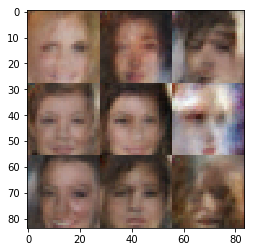

Step 5610  d_loss: 1.2774... g_loss: 0.8213
Step 5620  d_loss: 1.2457... g_loss: 0.6816
Step 5630  d_loss: 1.3514... g_loss: 0.7455
Step 5640  d_loss: 1.3548... g_loss: 0.8106
Step 5650  d_loss: 1.3424... g_loss: 0.7332
Step 5660  d_loss: 1.4428... g_loss: 0.8594
Step 5670  d_loss: 1.2263... g_loss: 0.8655
Step 5680  d_loss: 1.7124... g_loss: 0.6011
Step 5690  d_loss: 1.4162... g_loss: 0.6995
Step 5700  d_loss: 1.3635... g_loss: 0.6733


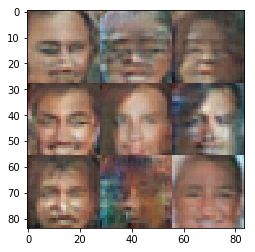

Step 5710  d_loss: 1.4008... g_loss: 0.7268
Step 5720  d_loss: 1.3035... g_loss: 0.8233
Step 5730  d_loss: 1.2833... g_loss: 0.8431
Step 5740  d_loss: 1.2344... g_loss: 0.8289
Step 5750  d_loss: 1.2915... g_loss: 0.7277
Step 5760  d_loss: 1.3543... g_loss: 0.7712
Step 5770  d_loss: 1.3335... g_loss: 0.8496
Step 5780  d_loss: 1.2321... g_loss: 0.8739
Step 5790  d_loss: 1.2487... g_loss: 0.8584
Step 5800  d_loss: 1.1401... g_loss: 0.9132


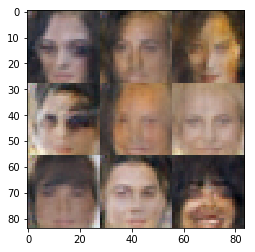

Step 5810  d_loss: 1.2653... g_loss: 0.7132
Step 5820  d_loss: 1.5395... g_loss: 0.6399
Step 5830  d_loss: 1.1208... g_loss: 0.7813
Step 5840  d_loss: 1.3985... g_loss: 0.8220
Step 5850  d_loss: 1.1540... g_loss: 0.7798
Step 5860  d_loss: 1.2378... g_loss: 0.7448
Step 5870  d_loss: 1.2859... g_loss: 0.7717
Step 5880  d_loss: 1.4086... g_loss: 0.7483
Step 5890  d_loss: 1.3759... g_loss: 0.7601
Step 5900  d_loss: 1.1900... g_loss: 0.7964


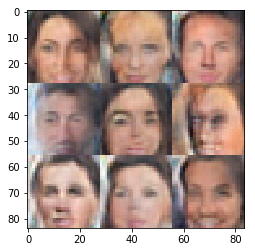

Step 5910  d_loss: 1.4344... g_loss: 0.7236
Step 5920  d_loss: 1.3501... g_loss: 0.7348
Step 5930  d_loss: 1.2182... g_loss: 0.8297
Step 5940  d_loss: 1.1026... g_loss: 0.9401
Step 5950  d_loss: 1.5312... g_loss: 0.6529
Step 5960  d_loss: 1.2368... g_loss: 0.9577
Step 5970  d_loss: 1.4842... g_loss: 0.6717
Step 5980  d_loss: 1.3405... g_loss: 0.7853
Step 5990  d_loss: 1.2593... g_loss: 0.9012
Step 6000  d_loss: 1.4334... g_loss: 0.7091


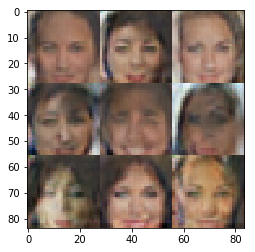

Step 6010  d_loss: 1.5280... g_loss: 0.7910
Step 6020  d_loss: 1.2310... g_loss: 0.7997
Step 6030  d_loss: 1.4986... g_loss: 0.6441
Step 6040  d_loss: 1.3804... g_loss: 0.6179
Step 6050  d_loss: 1.3640... g_loss: 0.6123
Step 6060  d_loss: 1.4497... g_loss: 0.7433
Step 6070  d_loss: 1.3271... g_loss: 0.6080
Step 6080  d_loss: 1.3499... g_loss: 0.8645
Step 6090  d_loss: 1.4970... g_loss: 0.6924
Step 6100  d_loss: 1.3214... g_loss: 0.7337


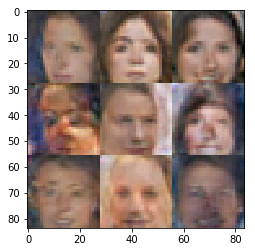

Step 6110  d_loss: 1.3390... g_loss: 0.8304
Step 6120  d_loss: 1.4228... g_loss: 0.7460
Step 6130  d_loss: 1.2189... g_loss: 0.7734
Step 6140  d_loss: 1.5164... g_loss: 0.7639
Step 6150  d_loss: 1.2858... g_loss: 0.6797
Step 6160  d_loss: 1.4762... g_loss: 0.8546
Step 6170  d_loss: 1.3766... g_loss: 1.0072
Step 6180  d_loss: 1.3923... g_loss: 0.8539
Step 6190  d_loss: 1.2816... g_loss: 0.8870
Step 6200  d_loss: 1.4894... g_loss: 0.9358


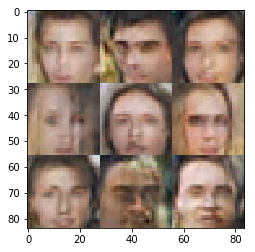

Step 6210  d_loss: 1.4021... g_loss: 0.8333
Step 6220  d_loss: 1.4212... g_loss: 0.8344
Step 6230  d_loss: 1.0902... g_loss: 0.7286
Step 6240  d_loss: 1.4401... g_loss: 0.6620
Step 6250  d_loss: 1.2805... g_loss: 0.7483
Step 6260  d_loss: 1.3434... g_loss: 0.9266
Step 6270  d_loss: 1.2865... g_loss: 0.6777
Step 6280  d_loss: 1.2376... g_loss: 0.8497
Step 6290  d_loss: 1.3167... g_loss: 0.8169
Step 6300  d_loss: 1.2002... g_loss: 0.8934


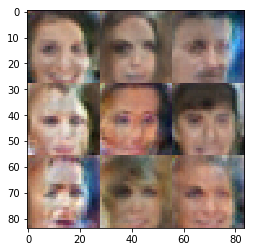

Step 6310  d_loss: 1.5704... g_loss: 0.7414
Step 6320  d_loss: 1.4672... g_loss: 0.6986
Step 6330  d_loss: 1.3625... g_loss: 0.8397
Step 6340  d_loss: 1.3264... g_loss: 0.8553
Step 6350  d_loss: 1.3809... g_loss: 0.7136
Step 6360  d_loss: 1.3454... g_loss: 0.9275
Step 6370  d_loss: 1.2831... g_loss: 0.7498
Step 6380  d_loss: 1.5372... g_loss: 0.6791
Step 6390  d_loss: 1.5076... g_loss: 0.6950
Step 6400  d_loss: 1.5078... g_loss: 0.6480


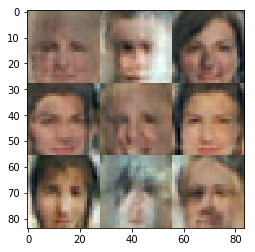

Step 6410  d_loss: 1.1330... g_loss: 0.7204
Step 6420  d_loss: 1.5008... g_loss: 0.7752
Step 6430  d_loss: 1.5283... g_loss: 0.5908
Step 6440  d_loss: 1.4754... g_loss: 0.8300
Step 6450  d_loss: 1.3584... g_loss: 0.6985
Step 6460  d_loss: 1.2662... g_loss: 0.8510
Step 6470  d_loss: 1.4488... g_loss: 0.6066
Step 6480  d_loss: 1.1651... g_loss: 1.0014
Step 6490  d_loss: 1.5376... g_loss: 0.6593
Step 6500  d_loss: 1.2692... g_loss: 0.7724


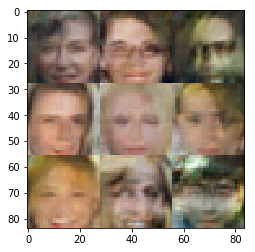

Step 6510  d_loss: 1.3372... g_loss: 0.7027
Step 6520  d_loss: 1.3236... g_loss: 0.7955
Step 6530  d_loss: 1.4108... g_loss: 0.7575
Step 6540  d_loss: 1.4286... g_loss: 0.6903
Step 6550  d_loss: 1.3456... g_loss: 0.7160
Step 6560  d_loss: 1.6865... g_loss: 0.6390
Step 6570  d_loss: 1.4214... g_loss: 0.6940
Step 6580  d_loss: 1.4428... g_loss: 0.7544
Step 6590  d_loss: 1.1513... g_loss: 0.7092
Step 6600  d_loss: 1.3710... g_loss: 0.8331


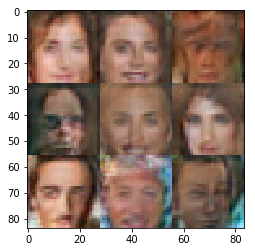

Step 6610  d_loss: 1.3533... g_loss: 0.8346
Step 6620  d_loss: 1.3459... g_loss: 0.8422
Step 6630  d_loss: 1.3402... g_loss: 0.8077
Step 6640  d_loss: 1.2187... g_loss: 0.8469
Step 6650  d_loss: 1.2095... g_loss: 0.9104
Step 6660  d_loss: 1.5096... g_loss: 0.6087
Step 6670  d_loss: 1.3430... g_loss: 0.7102
Step 6680  d_loss: 1.4508... g_loss: 0.8554
Step 6690  d_loss: 1.2856... g_loss: 0.7605
Step 6700  d_loss: 1.4438... g_loss: 0.8314


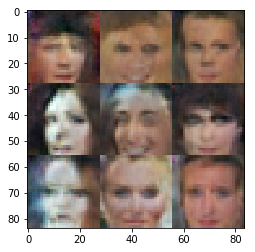

Step 6710  d_loss: 1.5171... g_loss: 0.6896
Step 6720  d_loss: 1.3052... g_loss: 0.8866
Step 6730  d_loss: 1.3302... g_loss: 0.7557
Step 6740  d_loss: 1.4152... g_loss: 0.5783
Step 6750  d_loss: 1.2600... g_loss: 0.7975
Step 6760  d_loss: 1.4936... g_loss: 0.8416
Step 6770  d_loss: 1.2034... g_loss: 0.8494
Step 6780  d_loss: 1.4277... g_loss: 0.7070
Step 6790  d_loss: 1.3162... g_loss: 0.7814
Step 6800  d_loss: 1.1725... g_loss: 0.7015


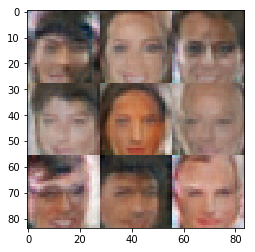

Step 6810  d_loss: 1.3414... g_loss: 0.8721
Step 6820  d_loss: 1.3441... g_loss: 0.7731
Step 6830  d_loss: 1.3038... g_loss: 0.8675
Step 6840  d_loss: 1.1743... g_loss: 0.8768
Step 6850  d_loss: 1.2106... g_loss: 0.9777
Step 6860  d_loss: 1.3755... g_loss: 0.7578
Step 6870  d_loss: 1.3550... g_loss: 0.8410
Step 6880  d_loss: 1.2348... g_loss: 0.7939
Step 6890  d_loss: 1.2934... g_loss: 0.8535
Step 6900  d_loss: 1.2135... g_loss: 0.8538


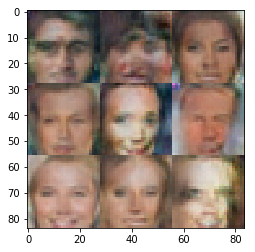

Step 6910  d_loss: 1.2842... g_loss: 0.6656
Step 6920  d_loss: 1.3494... g_loss: 0.7325
Step 6930  d_loss: 1.2796... g_loss: 0.8501
Step 6940  d_loss: 1.3267... g_loss: 0.8544
Step 6950  d_loss: 1.2695... g_loss: 0.8439
Step 6960  d_loss: 1.2164... g_loss: 0.8116
Step 6970  d_loss: 1.3987... g_loss: 0.7524
Step 6980  d_loss: 1.4278... g_loss: 0.7057
Step 6990  d_loss: 1.4299... g_loss: 0.6707
Step 7000  d_loss: 1.2955... g_loss: 0.8043


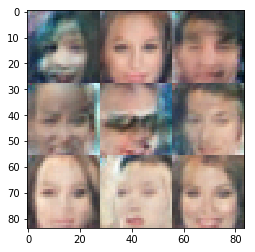

Step 7010  d_loss: 1.3825... g_loss: 0.8873
Step 7020  d_loss: 1.2140... g_loss: 0.9372
Step 7030  d_loss: 1.3225... g_loss: 0.7250
Step 7040  d_loss: 1.2878... g_loss: 0.6769
Step 7050  d_loss: 1.1535... g_loss: 0.8693
Step 7060  d_loss: 1.3765... g_loss: 0.7174
Step 7070  d_loss: 1.1710... g_loss: 0.8734
Step 7080  d_loss: 1.4072... g_loss: 0.6916
Step 7090  d_loss: 1.4276... g_loss: 0.7080
Step 7100  d_loss: 1.3950... g_loss: 0.6953


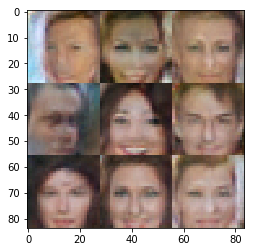

Step 7110  d_loss: 1.3078... g_loss: 0.7638
Step 7120  d_loss: 1.4810... g_loss: 0.7269
Step 7130  d_loss: 1.2905... g_loss: 0.7984
Step 7140  d_loss: 1.3029... g_loss: 0.7393
Step 7150  d_loss: 1.3209... g_loss: 0.7816
Step 7160  d_loss: 1.3425... g_loss: 0.7949
Step 7170  d_loss: 1.3928... g_loss: 0.8415
Step 7180  d_loss: 1.2855... g_loss: 0.7991
Step 7190  d_loss: 1.2852... g_loss: 0.8410
Step 7200  d_loss: 1.3732... g_loss: 0.8321


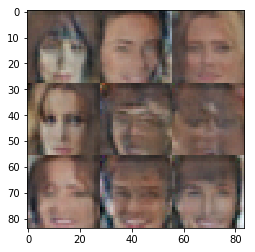

Step 7210  d_loss: 1.3847... g_loss: 0.9187
Step 7220  d_loss: 1.4223... g_loss: 0.7067
Step 7230  d_loss: 1.4702... g_loss: 0.5537
Step 7240  d_loss: 1.5265... g_loss: 0.7498
Step 7250  d_loss: 1.4449... g_loss: 0.5926
Step 7260  d_loss: 1.4500... g_loss: 0.6003
Step 7270  d_loss: 1.3209... g_loss: 0.6849
Step 7280  d_loss: 1.4643... g_loss: 0.6542
Step 7290  d_loss: 1.5219... g_loss: 0.7036
Step 7300  d_loss: 1.4152... g_loss: 0.7284


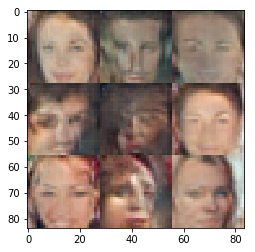

Step 7310  d_loss: 1.4356... g_loss: 0.8529
Step 7320  d_loss: 1.2159... g_loss: 0.8257
Step 7330  d_loss: 1.5076... g_loss: 0.7069
Step 7340  d_loss: 1.4779... g_loss: 0.7494
Step 7350  d_loss: 1.4499... g_loss: 0.7538
Step 7360  d_loss: 1.2902... g_loss: 0.7697
Step 7370  d_loss: 1.4543... g_loss: 0.8096
Step 7380  d_loss: 1.3018... g_loss: 0.7273
Step 7390  d_loss: 1.3719... g_loss: 0.6243
Step 7400  d_loss: 1.4597... g_loss: 0.6717


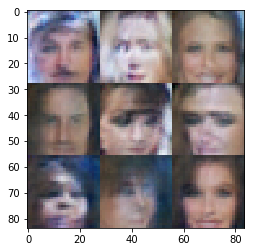

Step 7410  d_loss: 1.4434... g_loss: 0.6701
Step 7420  d_loss: 1.4347... g_loss: 0.7170
Step 7430  d_loss: 1.5085... g_loss: 0.6757
Step 7440  d_loss: 1.2301... g_loss: 0.8225
Step 7450  d_loss: 1.2016... g_loss: 0.9889
Step 7460  d_loss: 1.3649... g_loss: 0.7982
Step 7470  d_loss: 1.4694... g_loss: 0.6114
Step 7480  d_loss: 1.2178... g_loss: 0.7863
Step 7490  d_loss: 1.3867... g_loss: 0.7152
Step 7500  d_loss: 1.2332... g_loss: 0.7994


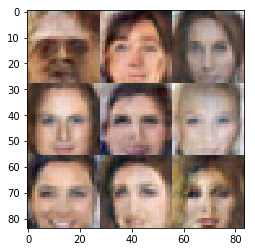

Step 7510  d_loss: 1.4466... g_loss: 0.7005
Step 7520  d_loss: 1.3230... g_loss: 0.8679
Step 7530  d_loss: 1.4702... g_loss: 0.5949
Step 7540  d_loss: 1.2897... g_loss: 0.7201
Step 7550  d_loss: 1.4185... g_loss: 0.7382
Step 7560  d_loss: 1.5238... g_loss: 0.6445
Step 7570  d_loss: 1.2808... g_loss: 0.8650
Step 7580  d_loss: 1.4582... g_loss: 0.6041
Step 7590  d_loss: 1.4760... g_loss: 0.6973
Step 7600  d_loss: 1.2016... g_loss: 0.9707


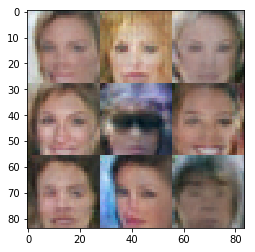

Step 7610  d_loss: 1.2070... g_loss: 0.7075
Step 7620  d_loss: 1.2366... g_loss: 0.7359
Step 7630  d_loss: 1.3107... g_loss: 0.7214
Step 7640  d_loss: 1.2135... g_loss: 0.9120
Step 7650  d_loss: 1.4213... g_loss: 0.7166
Step 7660  d_loss: 1.4134... g_loss: 0.6742
Step 7670  d_loss: 1.3684... g_loss: 0.6893
Step 7680  d_loss: 1.2079... g_loss: 0.8087
Step 7690  d_loss: 1.5152... g_loss: 0.6684
Step 7700  d_loss: 1.3763... g_loss: 0.7159


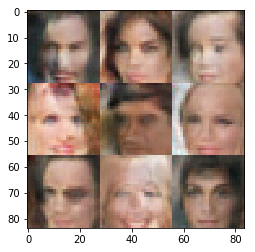

Step 7710  d_loss: 1.4982... g_loss: 0.6812
Step 7720  d_loss: 1.3156... g_loss: 0.7770
Step 7730  d_loss: 1.1749... g_loss: 0.9156
Step 7740  d_loss: 1.3115... g_loss: 0.6786
Step 7750  d_loss: 1.4576... g_loss: 0.6713
Step 7760  d_loss: 1.2287... g_loss: 0.7275
Step 7770  d_loss: 1.1967... g_loss: 0.8363
Step 7780  d_loss: 1.3620... g_loss: 0.8871
Step 7790  d_loss: 1.4630... g_loss: 0.6698
Step 7800  d_loss: 1.4442... g_loss: 0.8325


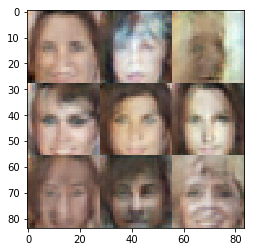

Step 7810  d_loss: 1.4651... g_loss: 0.5939
Step 7820  d_loss: 1.3069... g_loss: 0.7317
Step 7830  d_loss: 1.3053... g_loss: 0.8642
Step 7840  d_loss: 1.2450... g_loss: 0.7650
Step 7850  d_loss: 1.3170... g_loss: 0.7244
Step 7860  d_loss: 1.3745... g_loss: 0.6643
Step 7870  d_loss: 1.3593... g_loss: 0.7402
Step 7880  d_loss: 1.6945... g_loss: 0.5489
Step 7890  d_loss: 1.4885... g_loss: 0.6595
Step 7900  d_loss: 1.3796... g_loss: 0.7474


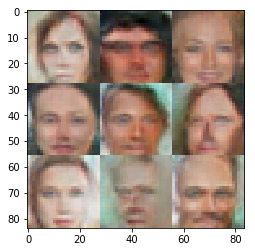

Step 7910  d_loss: 1.1414... g_loss: 0.9005
Step 7920  d_loss: 1.3537... g_loss: 0.6657
Step 7930  d_loss: 1.3092... g_loss: 0.7817
Step 7940  d_loss: 1.2741... g_loss: 0.8118
Step 7950  d_loss: 1.1114... g_loss: 0.9600
Step 7960  d_loss: 1.3656... g_loss: 0.6561
Step 7970  d_loss: 1.3431... g_loss: 0.8072
Step 7980  d_loss: 1.3222... g_loss: 0.8247
Step 7990  d_loss: 1.4642... g_loss: 0.7697
Step 8000  d_loss: 1.3030... g_loss: 0.6993


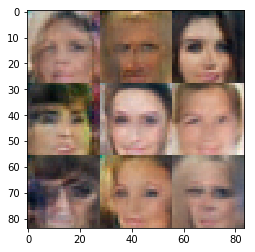

Step 8010  d_loss: 1.2531... g_loss: 0.8064
Step 8020  d_loss: 1.3247... g_loss: 0.8098
Step 8030  d_loss: 1.2587... g_loss: 0.6966
Step 8040  d_loss: 1.3120... g_loss: 0.7757
Step 8050  d_loss: 1.4139... g_loss: 0.8857
Step 8060  d_loss: 1.2833... g_loss: 0.7831
Step 8070  d_loss: 1.3865... g_loss: 0.7532
Step 8080  d_loss: 1.4963... g_loss: 0.6437
Step 8090  d_loss: 1.3533... g_loss: 0.7145
Step 8100  d_loss: 1.3745... g_loss: 0.6205


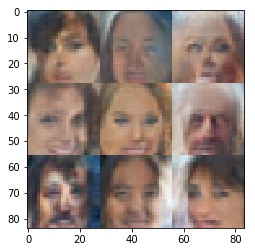

Step 8110  d_loss: 1.2858... g_loss: 0.7680
Step 8120  d_loss: 1.4180... g_loss: 0.8095
Step 8130  d_loss: 1.0906... g_loss: 0.8521
Step 8140  d_loss: 1.4143... g_loss: 0.6358
Step 8150  d_loss: 1.2854... g_loss: 0.8152
Step 8160  d_loss: 1.2417... g_loss: 0.8015
Step 8170  d_loss: 1.2557... g_loss: 0.7244
Step 8180  d_loss: 1.4700... g_loss: 0.7367
Step 8190  d_loss: 1.2410... g_loss: 0.8348
Step 8200  d_loss: 1.3002... g_loss: 0.7771


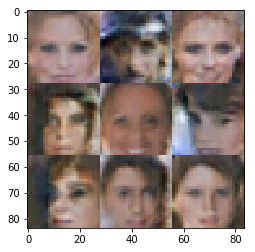

Step 8210  d_loss: 1.3756... g_loss: 0.7498
Step 8220  d_loss: 1.3792... g_loss: 0.7419
Step 8230  d_loss: 1.3741... g_loss: 0.7980
Step 8240  d_loss: 1.3452... g_loss: 0.7546
Step 8250  d_loss: 1.2014... g_loss: 0.8264
Step 8260  d_loss: 1.4280... g_loss: 0.7413
Step 8270  d_loss: 1.4015... g_loss: 0.9396
Step 8280  d_loss: 1.3421... g_loss: 0.6929
Step 8290  d_loss: 1.3277... g_loss: 0.6981
Step 8300  d_loss: 1.2170... g_loss: 0.7174


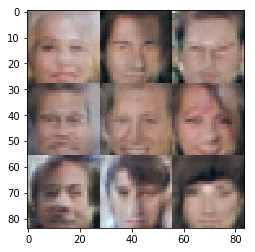

Step 8310  d_loss: 1.2839... g_loss: 0.7508
Step 8320  d_loss: 1.3388... g_loss: 0.8135
Step 8330  d_loss: 1.2900... g_loss: 0.7461
Step 8340  d_loss: 1.6237... g_loss: 0.6522
Step 8350  d_loss: 1.2206... g_loss: 0.8599
Step 8360  d_loss: 1.2960... g_loss: 0.8053
Step 8370  d_loss: 1.2909... g_loss: 0.8581
Step 8380  d_loss: 1.3221... g_loss: 0.8241
Step 8390  d_loss: 1.6010... g_loss: 0.5729
Step 8400  d_loss: 1.1892... g_loss: 0.8822


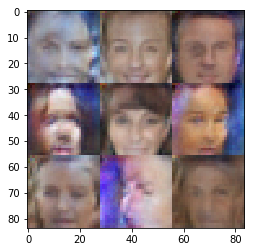

Step 8410  d_loss: 1.4634... g_loss: 0.6801
Step 8420  d_loss: 1.2986... g_loss: 0.7678
Step 8430  d_loss: 1.3257... g_loss: 0.7312
Step 8440  d_loss: 1.3819... g_loss: 0.6079
Step 8450  d_loss: 1.5540... g_loss: 0.6114
Step 8460  d_loss: 1.4007... g_loss: 0.6203
Step 8470  d_loss: 1.2761... g_loss: 0.7353
Step 8480  d_loss: 1.3809... g_loss: 0.7642
Step 8490  d_loss: 1.2419... g_loss: 0.8351
Step 8500  d_loss: 1.3671... g_loss: 0.8629


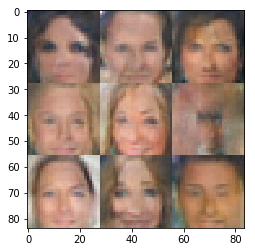

Step 8510  d_loss: 1.4354... g_loss: 0.8061
Step 8520  d_loss: 1.1677... g_loss: 0.8234
Step 8530  d_loss: 1.4004... g_loss: 0.7163
Step 8540  d_loss: 1.3981... g_loss: 0.6366
Step 8550  d_loss: 1.4387... g_loss: 0.7695
Step 8560  d_loss: 1.4348... g_loss: 0.7308
Step 8570  d_loss: 1.3476... g_loss: 0.7308
Step 8580  d_loss: 1.3687... g_loss: 0.8447
Step 8590  d_loss: 1.5659... g_loss: 0.6907
Step 8600  d_loss: 1.4713... g_loss: 0.8636


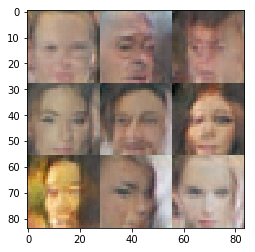

Step 8610  d_loss: 1.6003... g_loss: 0.5932
Step 8620  d_loss: 1.4943... g_loss: 0.6358
Step 8630  d_loss: 1.3096... g_loss: 0.7269
Step 8640  d_loss: 1.4962... g_loss: 0.7414
Step 8650  d_loss: 1.3175... g_loss: 0.7092
Step 8660  d_loss: 1.4086... g_loss: 0.7647
Step 8670  d_loss: 1.2492... g_loss: 0.7369
Step 8680  d_loss: 1.2785... g_loss: 0.7746
Step 8690  d_loss: 1.4714... g_loss: 0.7326
Step 8700  d_loss: 1.4103... g_loss: 0.7727


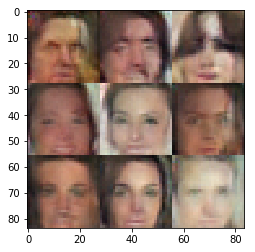

Step 8710  d_loss: 1.2485... g_loss: 0.6604
Step 8720  d_loss: 1.2831... g_loss: 0.8203
Step 8730  d_loss: 1.3346... g_loss: 0.7950
Step 8740  d_loss: 1.3796... g_loss: 0.7748
Step 8750  d_loss: 1.3457... g_loss: 0.7615
Step 8760  d_loss: 1.2047... g_loss: 0.8789
Step 8770  d_loss: 1.2330... g_loss: 0.8855
Step 8780  d_loss: 1.3519... g_loss: 0.7376
Step 8790  d_loss: 1.3878... g_loss: 0.7222
Step 8800  d_loss: 1.4439... g_loss: 0.7032


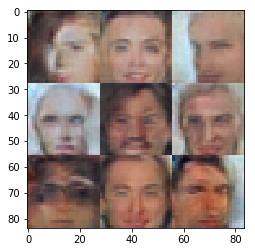

Step 8810  d_loss: 1.2712... g_loss: 0.7224
Step 8820  d_loss: 1.2464... g_loss: 0.8318
Step 8830  d_loss: 1.4433... g_loss: 0.6709
Step 8840  d_loss: 1.2968... g_loss: 0.7528
Step 8850  d_loss: 1.4847... g_loss: 0.7638
Step 8860  d_loss: 1.2856... g_loss: 0.7358
Step 8870  d_loss: 1.3942... g_loss: 0.7025
Step 8880  d_loss: 1.3110... g_loss: 0.8144
Step 8890  d_loss: 1.2992... g_loss: 0.7686
Step 8900  d_loss: 1.5157... g_loss: 0.5924


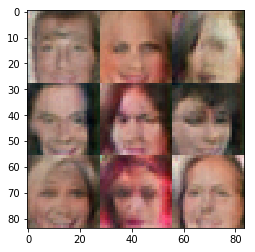

Step 8910  d_loss: 1.3606... g_loss: 0.7814
Step 8920  d_loss: 1.5320... g_loss: 0.6657
Step 8930  d_loss: 1.2217... g_loss: 0.8019
Step 8940  d_loss: 1.3021... g_loss: 0.6792
Step 8950  d_loss: 1.3705... g_loss: 0.6899
Step 8960  d_loss: 1.4685... g_loss: 0.7873
Step 8970  d_loss: 1.3986... g_loss: 0.8081
Step 8980  d_loss: 1.5720... g_loss: 0.7140
Step 8990  d_loss: 1.3467... g_loss: 0.6693
Step 9000  d_loss: 1.2505... g_loss: 0.7259


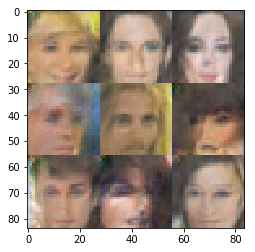

Step 9010  d_loss: 1.4982... g_loss: 0.6785
Step 9020  d_loss: 1.3396... g_loss: 0.6882
Step 9030  d_loss: 1.4856... g_loss: 0.7038
Step 9040  d_loss: 1.2032... g_loss: 0.6759
Step 9050  d_loss: 1.4453... g_loss: 0.8112
Step 9060  d_loss: 1.3203... g_loss: 0.6594
Step 9070  d_loss: 1.2763... g_loss: 0.7177
Step 9080  d_loss: 1.3465... g_loss: 0.7065
Step 9090  d_loss: 1.5122... g_loss: 0.7574
Step 9100  d_loss: 1.2048... g_loss: 0.7925


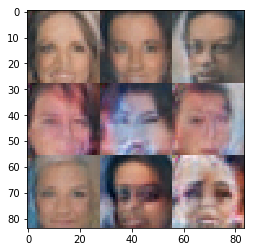

Step 9110  d_loss: 1.5018... g_loss: 0.6208
Step 9120  d_loss: 1.4379... g_loss: 0.7113
Step 9130  d_loss: 1.4108... g_loss: 0.6947
Step 9140  d_loss: 1.1551... g_loss: 1.0220
Step 9150  d_loss: 1.3472... g_loss: 0.7281
Step 9160  d_loss: 1.4024... g_loss: 0.7204
Step 9170  d_loss: 1.4277... g_loss: 0.7161
Step 9180  d_loss: 1.2356... g_loss: 0.6886
Step 9190  d_loss: 1.4507... g_loss: 0.7877
Step 9200  d_loss: 1.3963... g_loss: 0.8392


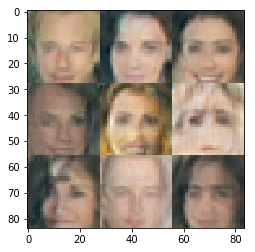

Step 9210  d_loss: 1.3590... g_loss: 0.7344
Step 9220  d_loss: 1.2059... g_loss: 0.7543
Step 9230  d_loss: 1.4301... g_loss: 0.7967
Step 9240  d_loss: 1.2959... g_loss: 0.7320
Step 9250  d_loss: 1.1510... g_loss: 0.7564
Step 9260  d_loss: 1.3352... g_loss: 0.7371
Step 9270  d_loss: 1.4966... g_loss: 0.7503
Step 9280  d_loss: 1.3165... g_loss: 0.8273
Step 9290  d_loss: 1.5954... g_loss: 0.6337
Step 9300  d_loss: 1.3975... g_loss: 0.6643


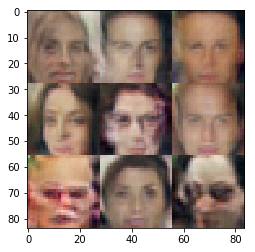

Step 9310  d_loss: 1.3148... g_loss: 0.8355
Step 9320  d_loss: 1.6849... g_loss: 0.4878
Step 9330  d_loss: 1.5081... g_loss: 0.5563
Step 9340  d_loss: 1.3256... g_loss: 0.7810
Step 9350  d_loss: 1.3394... g_loss: 0.8056
Step 9360  d_loss: 1.4087... g_loss: 0.6934
Step 9370  d_loss: 1.3249... g_loss: 0.6232
Step 9380  d_loss: 1.1474... g_loss: 0.8409
Step 9390  d_loss: 1.3346... g_loss: 0.7351
Step 9400  d_loss: 1.3528... g_loss: 0.8441


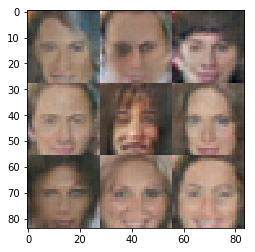

Step 9410  d_loss: 1.4621... g_loss: 0.7598
Step 9420  d_loss: 1.2967... g_loss: 0.8224
Step 9430  d_loss: 1.3073... g_loss: 0.7204
Step 9440  d_loss: 1.2499... g_loss: 0.8991
Step 9450  d_loss: 1.3058... g_loss: 0.8213
Step 9460  d_loss: 1.2143... g_loss: 0.6705
Step 9470  d_loss: 1.3954... g_loss: 0.7763
Step 9480  d_loss: 1.2088... g_loss: 0.7517
Step 9490  d_loss: 1.4724... g_loss: 0.6779
Step 9500  d_loss: 1.2811... g_loss: 0.7517


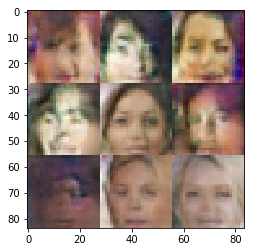

Step 9510  d_loss: 1.2861... g_loss: 0.7605
Step 9520  d_loss: 1.3896... g_loss: 0.6972
Step 9530  d_loss: 1.2600... g_loss: 0.7388
Step 9540  d_loss: 1.2864... g_loss: 0.7299
Step 9550  d_loss: 1.4374... g_loss: 0.7580
Step 9560  d_loss: 1.3027... g_loss: 0.7494
Step 9570  d_loss: 1.4027... g_loss: 0.8956
Step 9580  d_loss: 1.4010... g_loss: 0.7629
Step 9590  d_loss: 1.3413... g_loss: 0.7331
Step 9600  d_loss: 1.3983... g_loss: 0.7428


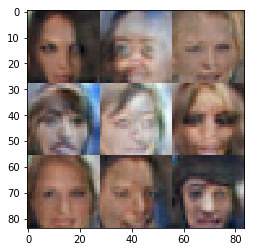

Step 9610  d_loss: 1.3331... g_loss: 0.6676
Step 9620  d_loss: 1.3009... g_loss: 0.8140
Step 9630  d_loss: 1.4352... g_loss: 0.7941
Step 9640  d_loss: 1.2632... g_loss: 0.7664
Step 9650  d_loss: 1.4326... g_loss: 0.6895
Step 9660  d_loss: 1.3392... g_loss: 0.8747
Step 9670  d_loss: 1.2933... g_loss: 0.7705
Step 9680  d_loss: 1.3435... g_loss: 0.8402
Step 9690  d_loss: 1.3647... g_loss: 0.8623
Step 9700  d_loss: 1.4820... g_loss: 0.7628


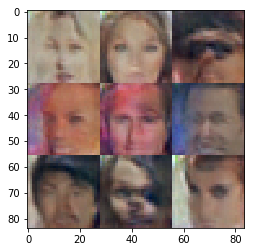

Step 9710  d_loss: 1.3117... g_loss: 0.7382
Step 9720  d_loss: 1.3677... g_loss: 0.6736
Step 9730  d_loss: 1.4139... g_loss: 0.6354
Step 9740  d_loss: 1.4539... g_loss: 0.6324
Step 9750  d_loss: 1.2564... g_loss: 0.6752
Step 9760  d_loss: 1.2373... g_loss: 1.0655
Step 9770  d_loss: 1.2884... g_loss: 0.8181
Step 9780  d_loss: 1.2301... g_loss: 0.7920
Step 9790  d_loss: 1.3826... g_loss: 0.5370
Step 9800  d_loss: 1.3984... g_loss: 0.7811


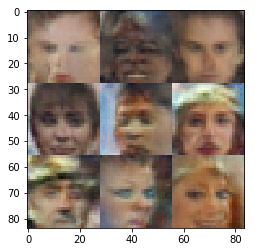

Step 9810  d_loss: 1.2751... g_loss: 0.6698
Step 9820  d_loss: 1.3216... g_loss: 0.6973
Step 9830  d_loss: 1.4295... g_loss: 0.7074
Step 9840  d_loss: 1.3462... g_loss: 0.7360
Step 9850  d_loss: 1.2829... g_loss: 0.7214
Step 9860  d_loss: 1.2219... g_loss: 0.7626
Step 9870  d_loss: 1.3075... g_loss: 0.7103
Step 9880  d_loss: 1.3622... g_loss: 0.7122
Step 9890  d_loss: 1.3547... g_loss: 0.7222
Step 9900  d_loss: 1.4654... g_loss: 0.6924


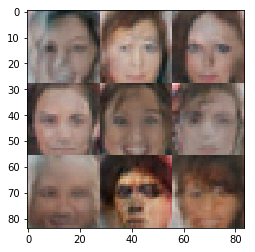

Step 9910  d_loss: 1.3654... g_loss: 0.7663
Step 9920  d_loss: 1.4046... g_loss: 0.7593
Step 9930  d_loss: 1.5358... g_loss: 0.6333
Step 9940  d_loss: 1.2528... g_loss: 0.7445
Step 9950  d_loss: 1.5907... g_loss: 0.7153
Step 9960  d_loss: 1.2715... g_loss: 0.8554
Step 9970  d_loss: 1.3354... g_loss: 0.6835
Step 9980  d_loss: 1.2531... g_loss: 0.9585
Step 9990  d_loss: 1.4077... g_loss: 0.7251
Step 10000  d_loss: 1.4189... g_loss: 0.8157


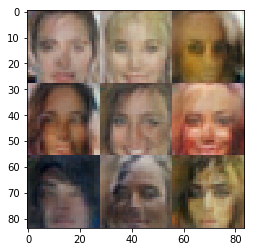

Step 10010  d_loss: 1.3609... g_loss: 0.6704
Step 10020  d_loss: 1.2415... g_loss: 0.7826
Step 10030  d_loss: 1.2653... g_loss: 0.8448
Step 10040  d_loss: 1.4615... g_loss: 0.7217
Step 10050  d_loss: 1.3611... g_loss: 0.7650
Step 10060  d_loss: 1.4722... g_loss: 0.7621
Step 10070  d_loss: 1.1350... g_loss: 0.9063
Step 10080  d_loss: 1.3786... g_loss: 0.7914
Step 10090  d_loss: 1.3272... g_loss: 0.7506
Step 10100  d_loss: 1.3221... g_loss: 0.6997


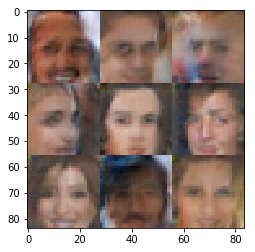

Step 10110  d_loss: 1.2903... g_loss: 0.8370
Step 10120  d_loss: 1.1515... g_loss: 0.8197
Step 10130  d_loss: 1.3539... g_loss: 0.7230
Step 10140  d_loss: 1.4108... g_loss: 0.6852
Step 10150  d_loss: 1.3087... g_loss: 0.7535
Step 10160  d_loss: 1.2317... g_loss: 0.6825
Step 10170  d_loss: 1.5629... g_loss: 0.5905
Step 10180  d_loss: 1.2214... g_loss: 0.7030
Step 10190  d_loss: 1.3215... g_loss: 0.8411
Step 10200  d_loss: 1.4771... g_loss: 0.7899


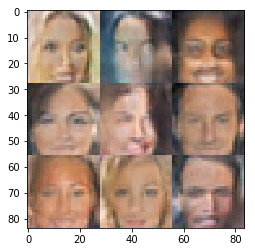

Step 10210  d_loss: 1.3293... g_loss: 0.8094
Step 10220  d_loss: 1.4907... g_loss: 0.6875
Step 10230  d_loss: 1.3609... g_loss: 0.7682
Step 10240  d_loss: 1.4336... g_loss: 0.6196
Step 10250  d_loss: 1.4595... g_loss: 0.6753
Step 10260  d_loss: 1.4029... g_loss: 0.7515
Step 10270  d_loss: 1.2085... g_loss: 0.8436
Step 10280  d_loss: 1.5748... g_loss: 0.6508
Step 10290  d_loss: 1.2585... g_loss: 0.6522
Step 10300  d_loss: 1.3463... g_loss: 0.8066


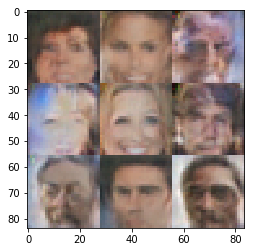

Step 10310  d_loss: 1.2621... g_loss: 0.6878
Step 10320  d_loss: 1.3616... g_loss: 0.6550
Step 10330  d_loss: 1.4786... g_loss: 0.6436
Step 10340  d_loss: 1.3472... g_loss: 0.7568
Step 10350  d_loss: 1.4104... g_loss: 0.6945
Step 10360  d_loss: 1.5186... g_loss: 0.7553
Step 10370  d_loss: 1.3595... g_loss: 0.8795
Step 10380  d_loss: 1.3267... g_loss: 0.7532
Step 10390  d_loss: 1.2837... g_loss: 0.7208
Step 10400  d_loss: 1.2936... g_loss: 0.7110


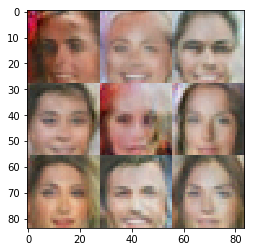

Step 10410  d_loss: 1.1086... g_loss: 0.8578
Step 10420  d_loss: 1.4104... g_loss: 0.7289
Step 10430  d_loss: 1.2756... g_loss: 0.7808
Step 10440  d_loss: 1.3333... g_loss: 0.7845
Step 10450  d_loss: 1.3330... g_loss: 0.8400
Step 10460  d_loss: 1.2454... g_loss: 0.8424
Step 10470  d_loss: 1.4906... g_loss: 0.6180
Step 10480  d_loss: 1.2598... g_loss: 0.8213
Step 10490  d_loss: 1.2357... g_loss: 0.7881
Step 10500  d_loss: 1.3344... g_loss: 0.8729


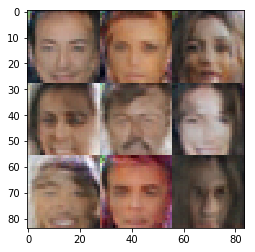

Step 10510  d_loss: 1.2829... g_loss: 0.6908
Step 10520  d_loss: 1.3797... g_loss: 0.7497
Step 10530  d_loss: 1.2509... g_loss: 0.7869
Step 10540  d_loss: 1.2884... g_loss: 0.8072
Step 10550  d_loss: 1.3945... g_loss: 0.7501
Step 10560  d_loss: 1.4368... g_loss: 0.8359
Step 10570  d_loss: 1.4021... g_loss: 0.8178
Step 10580  d_loss: 1.2866... g_loss: 0.7419
Step 10590  d_loss: 1.3921... g_loss: 0.7169
Step 10600  d_loss: 1.5292... g_loss: 0.7792


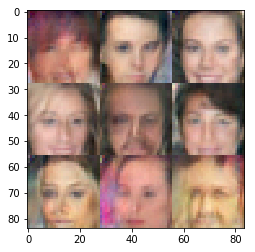

Step 10610  d_loss: 1.1584... g_loss: 0.8976
Step 10620  d_loss: 1.3117... g_loss: 0.6875
Step 10630  d_loss: 1.3419... g_loss: 0.7086
Step 10640  d_loss: 1.4261... g_loss: 0.6521
Step 10650  d_loss: 1.4018... g_loss: 0.8427
Step 10660  d_loss: 1.3250... g_loss: 0.6714
Step 10670  d_loss: 1.3520... g_loss: 0.7721
Step 10680  d_loss: 1.4618... g_loss: 0.5920
Step 10690  d_loss: 1.4317... g_loss: 0.8385
Step 10700  d_loss: 1.2118... g_loss: 0.9612


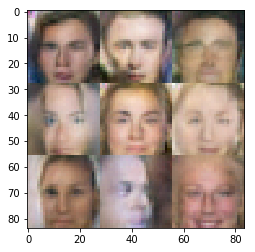

Step 10710  d_loss: 1.3531... g_loss: 0.6954
Step 10720  d_loss: 1.3636... g_loss: 0.7919
Step 10730  d_loss: 1.3288... g_loss: 0.7475
Step 10740  d_loss: 1.3260... g_loss: 0.7871
Step 10750  d_loss: 1.3760... g_loss: 0.7678
Step 10760  d_loss: 1.2642... g_loss: 0.8323
Step 10770  d_loss: 1.3538... g_loss: 0.7050
Step 10780  d_loss: 1.3242... g_loss: 0.8882
Step 10790  d_loss: 1.3517... g_loss: 0.7569
Step 10800  d_loss: 1.3679... g_loss: 0.6537


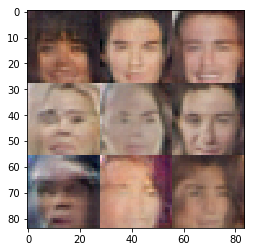

Step 10810  d_loss: 1.3889... g_loss: 0.7720
Step 10820  d_loss: 1.2013... g_loss: 0.7714
Step 10830  d_loss: 1.3799... g_loss: 0.7391
Step 10840  d_loss: 1.3051... g_loss: 0.8689
Step 10850  d_loss: 1.4260... g_loss: 0.7869
Step 10860  d_loss: 1.3062... g_loss: 0.7607
Step 10870  d_loss: 1.3891... g_loss: 0.7838
Step 10880  d_loss: 1.1984... g_loss: 0.7473
Step 10890  d_loss: 1.4044... g_loss: 0.6402
Step 10900  d_loss: 1.3853... g_loss: 0.8661


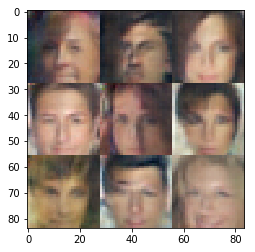

Step 10910  d_loss: 1.3980... g_loss: 0.7618
Step 10920  d_loss: 1.3034... g_loss: 0.8298
Step 10930  d_loss: 1.3074... g_loss: 0.7299
Step 10940  d_loss: 1.4472... g_loss: 0.6806
Step 10950  d_loss: 1.3226... g_loss: 0.6818
Step 10960  d_loss: 1.3342... g_loss: 0.6190
Step 10970  d_loss: 1.3723... g_loss: 0.7479
Step 10980  d_loss: 1.4028... g_loss: 0.7027
Step 10990  d_loss: 1.4538... g_loss: 0.6961
Step 11000  d_loss: 1.4673... g_loss: 0.7146


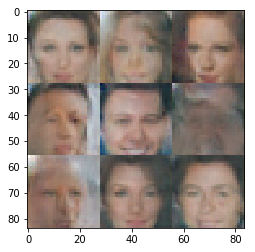

Step 11010  d_loss: 1.4463... g_loss: 0.7070
Step 11020  d_loss: 1.5092... g_loss: 0.6133
Step 11030  d_loss: 1.2227... g_loss: 0.9003
Step 11040  d_loss: 1.2129... g_loss: 0.8260
Step 11050  d_loss: 1.2109... g_loss: 0.7827
Step 11060  d_loss: 1.3503... g_loss: 0.8440
Step 11070  d_loss: 1.5696... g_loss: 0.6158
Step 11080  d_loss: 1.3671... g_loss: 0.6696
Step 11090  d_loss: 1.3430... g_loss: 0.6617
Step 11100  d_loss: 1.4013... g_loss: 0.7534


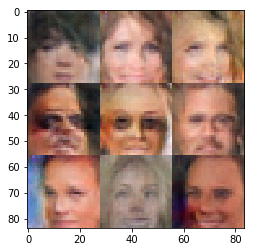

Step 11110  d_loss: 1.3835... g_loss: 0.8640
Step 11120  d_loss: 1.3533... g_loss: 0.8667
Step 11130  d_loss: 1.3154... g_loss: 0.9553
Step 11140  d_loss: 1.3321... g_loss: 0.7484
Step 11150  d_loss: 1.4286... g_loss: 0.6644
Step 11160  d_loss: 1.4806... g_loss: 0.7513
Step 11170  d_loss: 1.3194... g_loss: 0.7358
Step 11180  d_loss: 1.2874... g_loss: 0.8298
Step 11190  d_loss: 1.3150... g_loss: 0.7824
Step 11200  d_loss: 1.2229... g_loss: 0.7769


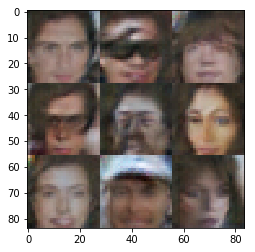

Step 11210  d_loss: 1.4853... g_loss: 0.7374
Step 11220  d_loss: 1.2784... g_loss: 0.8125
Step 11230  d_loss: 1.3488... g_loss: 0.7864
Step 11240  d_loss: 1.3152... g_loss: 0.6938
Step 11250  d_loss: 1.3561... g_loss: 0.6325
Step 11260  d_loss: 1.3645... g_loss: 0.7562
Step 11270  d_loss: 1.4139... g_loss: 0.7212
Step 11280  d_loss: 1.3247... g_loss: 0.7387
Step 11290  d_loss: 1.3007... g_loss: 0.7815
Step 11300  d_loss: 1.3004... g_loss: 0.7422


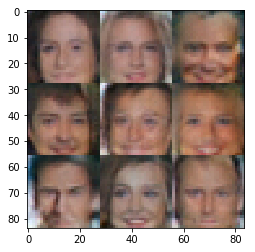

Step 11310  d_loss: 1.3458... g_loss: 0.7962
Step 11320  d_loss: 1.2179... g_loss: 0.8640
Step 11330  d_loss: 1.5151... g_loss: 0.5821
Step 11340  d_loss: 1.3396... g_loss: 0.7592
Step 11350  d_loss: 1.2254... g_loss: 0.8546
Step 11360  d_loss: 1.2190... g_loss: 0.9800
Step 11370  d_loss: 1.4096... g_loss: 0.7234
Step 11380  d_loss: 1.4327... g_loss: 0.6622
Step 11390  d_loss: 1.3197... g_loss: 0.8108
Step 11400  d_loss: 1.2156... g_loss: 0.9056


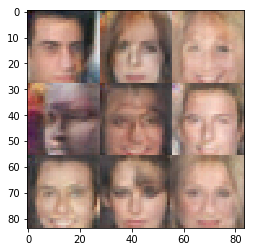

Step 11410  d_loss: 1.3661... g_loss: 0.7342
Step 11420  d_loss: 1.3068... g_loss: 0.8099
Step 11430  d_loss: 1.3016... g_loss: 0.6701
Step 11440  d_loss: 1.3997... g_loss: 0.9324
Step 11450  d_loss: 1.4620... g_loss: 0.7035
Step 11460  d_loss: 1.4509... g_loss: 0.6097
Step 11470  d_loss: 1.2771... g_loss: 0.7316
Step 11480  d_loss: 1.4553... g_loss: 0.6358
Step 11490  d_loss: 1.3235... g_loss: 0.7540
Step 11500  d_loss: 1.3540... g_loss: 0.7501


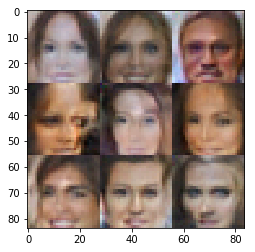

Step 11510  d_loss: 1.3462... g_loss: 0.7986
Step 11520  d_loss: 1.1541... g_loss: 0.8733
Step 11530  d_loss: 1.3745... g_loss: 0.8166
Step 11540  d_loss: 1.3912... g_loss: 0.7041
Step 11550  d_loss: 1.3060... g_loss: 0.8284
Step 11560  d_loss: 1.4013... g_loss: 0.6986
Step 11570  d_loss: 1.4641... g_loss: 0.6230
Step 11580  d_loss: 1.4611... g_loss: 0.6653
Step 11590  d_loss: 1.1939... g_loss: 0.7875
Step 11600  d_loss: 1.2430... g_loss: 0.8041


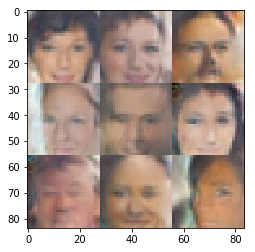

Step 11610  d_loss: 1.1304... g_loss: 0.9380
Step 11620  d_loss: 1.4488... g_loss: 0.7510
Step 11630  d_loss: 1.3410... g_loss: 0.6755
Step 11640  d_loss: 1.4589... g_loss: 0.7796
Step 11650  d_loss: 1.2385... g_loss: 0.7483
Step 11660  d_loss: 1.4557... g_loss: 0.7314
Step 11670  d_loss: 1.1415... g_loss: 0.8920
Step 11680  d_loss: 1.3744... g_loss: 0.8551
Step 11690  d_loss: 1.4523... g_loss: 0.9011
Step 11700  d_loss: 1.3633... g_loss: 0.7452


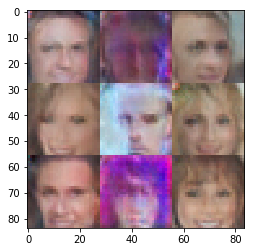

Step 11710  d_loss: 1.2159... g_loss: 0.7734
Step 11720  d_loss: 1.2054... g_loss: 0.8920
Step 11730  d_loss: 1.3143... g_loss: 0.7695
Step 11740  d_loss: 1.3635... g_loss: 0.7872
Step 11750  d_loss: 1.3061... g_loss: 0.9352
Step 11760  d_loss: 1.4928... g_loss: 0.6564
Step 11770  d_loss: 1.1706... g_loss: 0.7469
Step 11780  d_loss: 1.3235... g_loss: 0.8092
Step 11790  d_loss: 1.3048... g_loss: 0.7496
Step 11800  d_loss: 1.4388... g_loss: 0.6539


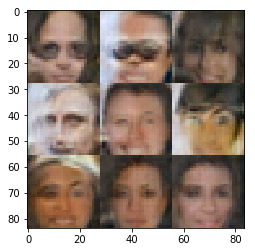

Step 11810  d_loss: 1.4177... g_loss: 0.6402
Step 11820  d_loss: 1.3535... g_loss: 0.7580
Step 11830  d_loss: 1.3748... g_loss: 0.6837
Step 11840  d_loss: 1.3494... g_loss: 0.8673
Step 11850  d_loss: 1.3925... g_loss: 0.7581
Step 11860  d_loss: 1.1514... g_loss: 0.8095
Step 11870  d_loss: 1.4639... g_loss: 0.8126
Step 11880  d_loss: 1.5353... g_loss: 0.6643
Step 11890  d_loss: 1.4296... g_loss: 0.7403
Step 11900  d_loss: 1.4201... g_loss: 0.7465


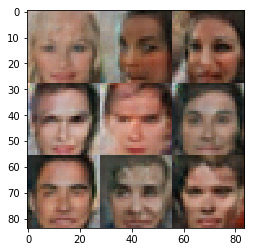

Step 11910  d_loss: 1.2785... g_loss: 0.7661
Step 11920  d_loss: 1.3384... g_loss: 0.7493
Step 11930  d_loss: 1.2858... g_loss: 0.8033
Step 11940  d_loss: 1.4002... g_loss: 0.6767
Step 11950  d_loss: 1.4291... g_loss: 0.7120
Step 11960  d_loss: 1.4702... g_loss: 0.6630
Step 11970  d_loss: 1.4430... g_loss: 0.6981


In [ ]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.